In [335]:
import os
import numpy as np
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from scipy.special import softmax
import time

In [ ]:
'''
dataset : KARATE CLUB 

Zachary, Wayne W. “An Information Flow Model for Conflict and Fission in Small Groups.” 
Journal of Anthropological Research, 33, 452–473, (1977).

More INFO at https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.generators.social.karate_club_graph.html
'''

In [246]:
#sample dataset to help with dimensions, and checking the output
g = nx.karate_club_graph()

In [247]:
g.number_of_edges(), g.number_of_nodes()

(78, 34)

In [248]:
#embedding positions in 2d for graph layout
pos = nx.spring_layout(g)
pos

{0: array([0.42368613, 0.22951694]),
 1: array([ 0.3741854 , -0.12180012]),
 2: array([ 0.02544078, -0.04433413]),
 3: array([0.46872448, 0.02245678]),
 4: array([0.86622099, 0.45208776]),
 5: array([0.72366663, 0.74367985]),
 6: array([0.85696508, 0.66182575]),
 7: array([0.31883185, 0.11833038]),
 8: array([-0.07772941, -0.11994372]),
 9: array([-0.06498717, -0.50358642]),
 10: array([0.69906719, 0.54918738]),
 11: array([0.3892446 , 0.70980099]),
 12: array([0.83137097, 0.13190663]),
 13: array([ 0.15937609, -0.04276379]),
 14: array([-0.70997456, -0.51936306]),
 15: array([-0.50417302, -0.67840711]),
 16: array([0.99100758, 1.        ]),
 17: array([ 0.70830699, -0.15685016]),
 18: array([-0.35677563, -0.67771101]),
 19: array([ 0.1667517 , -0.21040147]),
 20: array([-0.64412428, -0.64659895]),
 21: array([0.71690614, 0.00726562]),
 22: array([-0.71241151, -0.34107329]),
 23: array([-0.69323861, -0.02771334]),
 24: array([-0.57520551,  0.44807976]),
 25: array([-0.72395679,  0.3262

In [367]:
#ideal community detection, creating label for three communities of dimension (num_nodes, num_community)

community =  greedy_modularity_communities(g)
label_map = np.zeros(g.number_of_nodes())

for i, col in enumerate(community):
    label_map[list(col)] = i
    
labels = np.zeros([g.number_of_nodes(), len(set(community))])

for i in range(labels.shape[0]):
    labels[i,int(label_map[i])] = 1


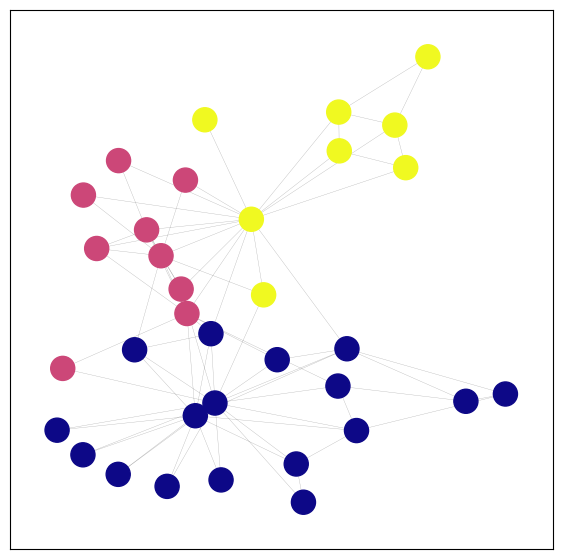

In [250]:
#coloring different communities based on their label, with IDEAL embeddings 

colorlist = ['#e41a1c', '#377eb8', '#4daf4a']

pos = nx.spring_layout(g, seed=42)

plt.figure(figsize=(7,7))
nodes = nx.draw_networkx_nodes(g, pos,
                               cmap=plt.cm.plasma,
                               node_color=label_map)
edges = nx.draw_networkx_edges(g, pos, width=0.25, alpha=0.3)
plt.show()


In [251]:
#adjacency matrix
A = nx.to_numpy_matrix(g)
A

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

# Pre-processing data for GCN Implementation

In [368]:
# Calculate D^-0.5 * A _hat * D^-0.5

#think of D as message passing matrix, aggregates neighborhood information and adds it to the current node

D = np.zeros_like(A)
np.fill_diagonal(D, np.array(np.sum(A,1)))

A_add_connection = np.eye(A.shape[0]) + A 

A_hat = np.linalg.inv(np.sqrt(D))@A_add_connection@np.linalg.inv(np.sqrt(D))


In [369]:
A.shape[0]

34

In [370]:
# because we dont ave associated features, we will consider each node number as one feature
X = np.eye(g.number_of_nodes())


In [371]:
A_hat.shape

(34, 34)

# Implementing GCN and SoftMax classes

In [257]:
#implementing GCN class
    # N is number of nodes
    # f is input_features
    # h is output_features
    
    #so, dimensions of following matrices are :
        # W (h,f)
        # H (N,h)
        # grad (N,h)ca

class GCNLayer:
    
    def __init__(self, input_len, output_len, activation):
        self.input_len = input_len     # input of size (N,f) where f are features
        self.output_len = output_len   # output of size (N,h) where h is hidden layer features
        self.weight = np.random.rand(output_len, input_len)-0.5 # weights of size (h,f)
        self.activation = activation
        
    def __repr__(self):
        return (f"GCNLayer Layer : Dimensions ({self.input_len},{self.output_len})")
    
    def forward(self, A, X):
        # A -> (N,N)
        # X -> (N,f)
        self.A = A   #A -> (f,N)
        self.X = X
        H = self.weight@(self.A@X).T # H is of size (h,N)
        #passing H through activation 
        self.H = self.activation(H.T)
        return self.H #output is (N,h)
    
    def backward(self, grad, lr):
        
        self.grad=grad

        dtanh = 1 - np.asarray(self.H)**2 # (N, h)

        d2 = np.multiply(self.grad, dtanh)  # (N, h) *element_wise* -> (N, h)

        #weight error
        dW = (d2.T)@self.X # (h,N)*(N,f) -> (h,f)
        
        #gradient to be sent back
        self.grad = self.A @ d2 @ self.weight  #(N,N)*(N,h)*(h,f) -> (N,f)
        self.weight -= lr* dW
        
        return self.grad
        

In [258]:
class SoftMax():
    
    def __init__(self, input_len, output_len):
        self.input_len = input_len     # input of size (N,f) where f are features
        self.output_len = output_len   # output of size (N,h) where h is hidden layer features
        self.weight = np.random.rand(self.output_len, self.input_len)-0.5 # weights of size (h,f)
        self.bias = np.random.rand(self.output_len,1)-0.5
        
    def __repr__(self):
        return (f"SoftMax Layer : Dimensions ({self.input_len},{self.output_len})")
    
    def norm_rows(self, proj):
        return softmax(proj, axis=1)
        
    def forward(self, X):
        self.X = X  # dimension (N,f)
        H = (self.weight@self.X.T)+self.bias # dim becomes (h,N)
        self.H = self.norm_rows(H.T)
        return self.H # dim becomes (N,h)
    
    def backward(self, grad, lr):
        #grad (N,h)
        
        self.grad = grad
        
        dW = self.grad.T @ self.X #dW (h,f)
        dB = np.sum(self.grad.T,1) #DB (h,1)
        
        self.grad = self.grad@self.weight #input_error (N,f)
        
        self.weight -= dW*lr
        self.bias -= dB.reshape(self.bias.shape)*lr

        return self.grad

        



In [286]:
class GCN_Network():
    
    def __init__(self, num_layer, hidden_size, input_len, output_len, loss=None):
        self.layers = []
        self.loss = None
        self.num_layer = num_layer
        self.hidden_size = hidden_size
        self.input_len = input_len
        self.output_len = output_len
        
    #create first layer
        self.layers.append(GCNLayer(self.input_len, self.hidden_size[0],np.tanh))

        for i in range(1,self.num_layer):
            layer_instance = GCNLayer(hidden_size[i-1],self.hidden_size[i],np.tanh)
            self.layers.append(layer_instance)

        self.layers.append(SoftMax(self.hidden_size[-1],self.output_len))
        
    def __repr__(self):
        return '\n'.join([str(l) for l in self.layers]) 
    
    def embedding(self, A, X):
        H = X
        for layer in self.layers[:-1]:
            H = layer.forward(A, H)
        return H 
    
    def forward(self, A, X):
        H = self.embedding(A, X)
        out = self.layers[-1].forward(H)
        return out
    
    def fit(self, A, X, label, epochs, lr):
        
        self.epochs = epochs
        loss_train = []
        loss_epoch = 0
        self.lr = lr
        self.embeddings = {}
        
        for epoch in range(self.epochs):
            y_pred = self.forward(A, X)
            
            loss_epoch = log_loss(np.asarray(labels), np.asarray(y_pred))
            loss_train.append(loss_epoch)
            
            #y_pred = softmax(y_pred)
            grad = y_pred-label
            
            for layer in reversed(self.layers):
                grad = layer.backward(grad, lr)
                
            self.embeddings[epoch] = self.embedding(A, X)
    
            if epoch % 10 == 0:
                print(f"Epoch: {epoch+1}, Train Loss: {loss_epoch}")
                
        return y_pred, self.embeddings, loss_train

 
    

In [289]:
#training the model 
num_nodes =g.number_of_nodes()
num_classes = labels.shape[1]
num_epochs =100
g_nn = GCN_Network(3, [16,8,2], num_nodes, num_classes)
y_pred, embed, loss_train = g_nn.fit(A_hat, X, labels, num_epochs, 0.1)



Epoch: 1, Train Loss: 1.1698263830124436
Epoch: 11, Train Loss: 0.3617177588864386
Epoch: 21, Train Loss: 0.6200904214485012
Epoch: 31, Train Loss: 0.4465075207307985
Epoch: 41, Train Loss: 0.4346976975031976
Epoch: 51, Train Loss: 0.165818539120975
Epoch: 61, Train Loss: 0.17516140151773363
Epoch: 71, Train Loss: 0.016296197758681467
Epoch: 81, Train Loss: 0.009980834552545009
Epoch: 91, Train Loss: 0.007399300705152947


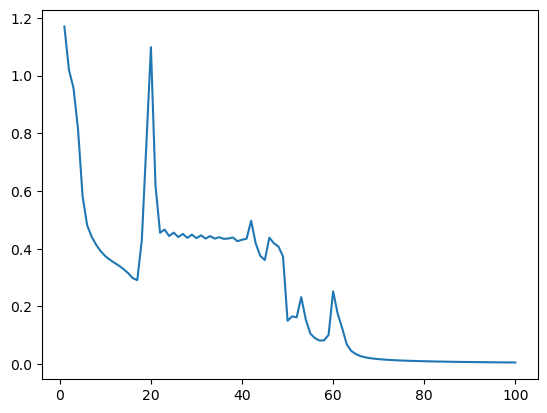

In [291]:
#plot loss function
epochs = np.arange(1,num_epochs+1)

plt.plot(epochs, loss_train)
plt.show()


C:\Users\nyadav\AppData\Local\Temp\ipykernel_28372\2456405003.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(7,7))


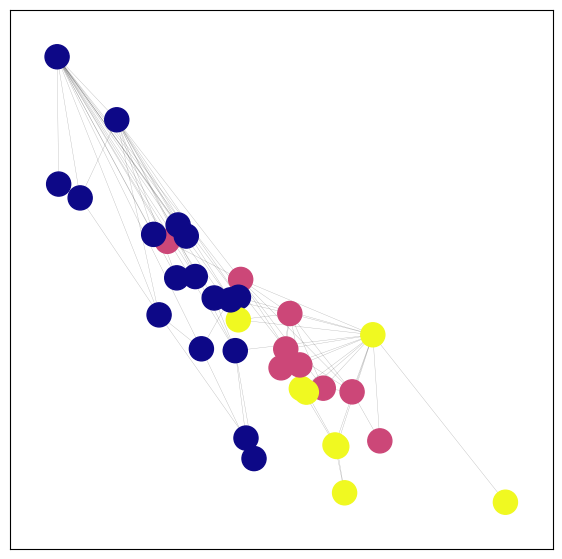

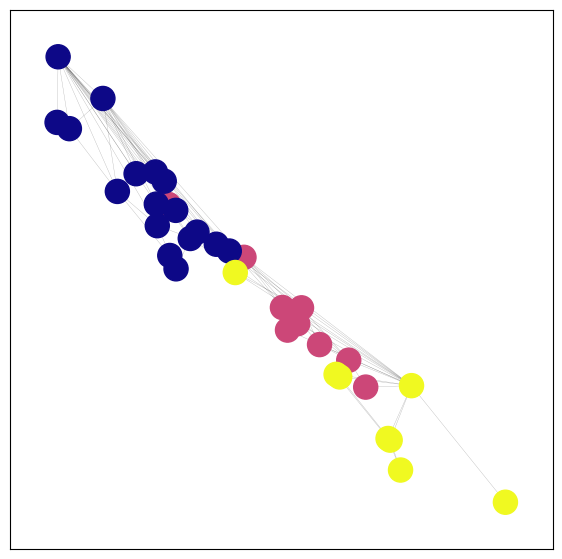

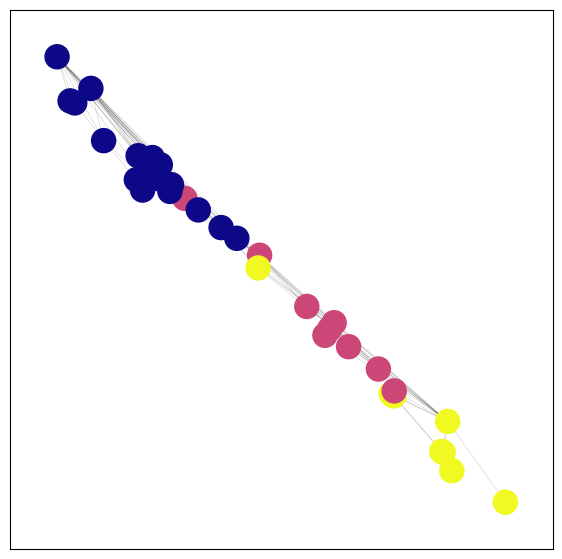

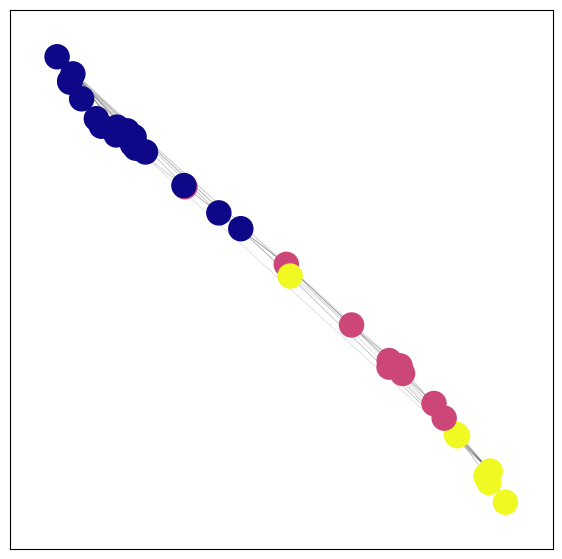

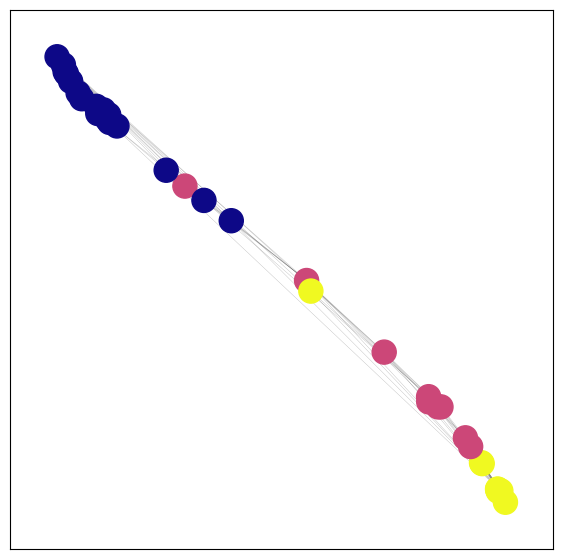

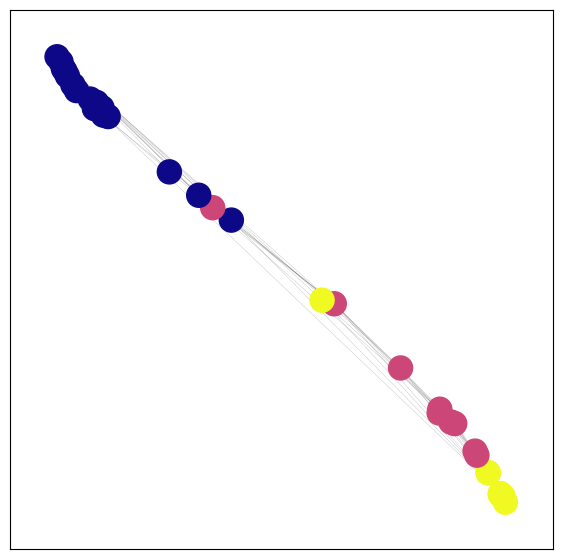

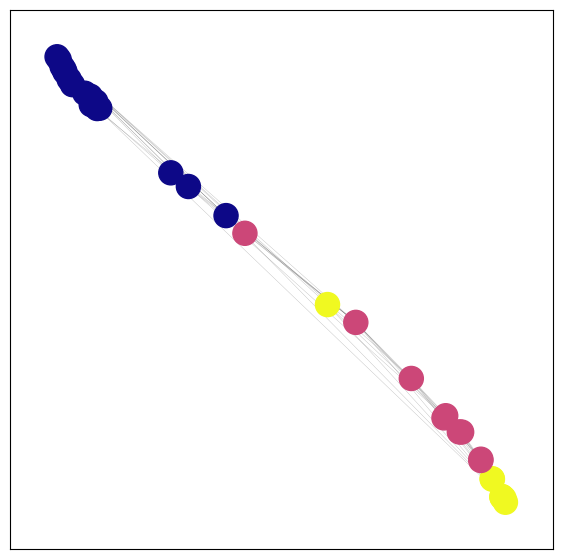

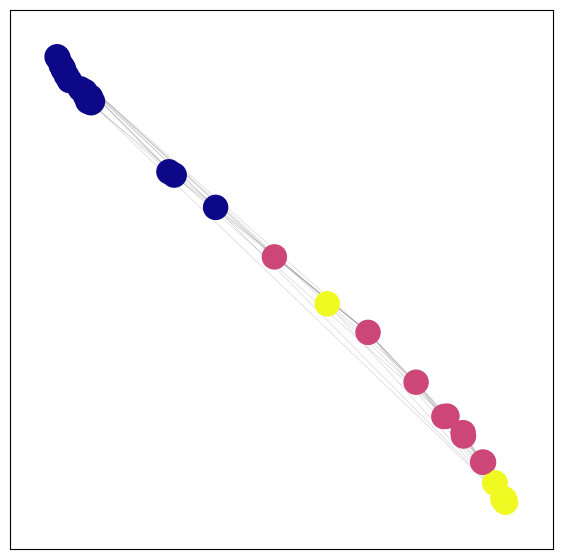

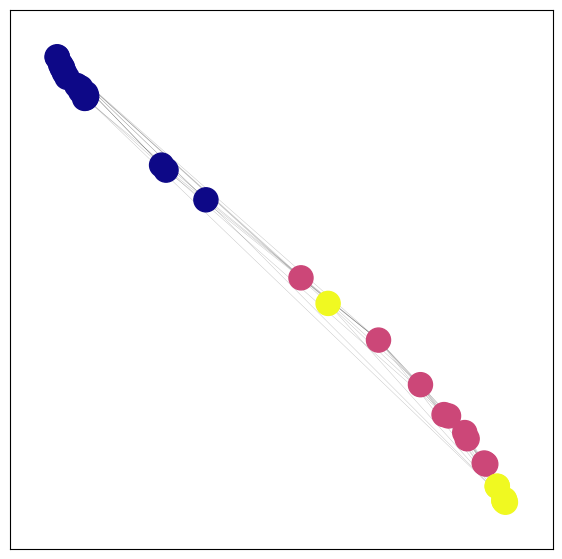

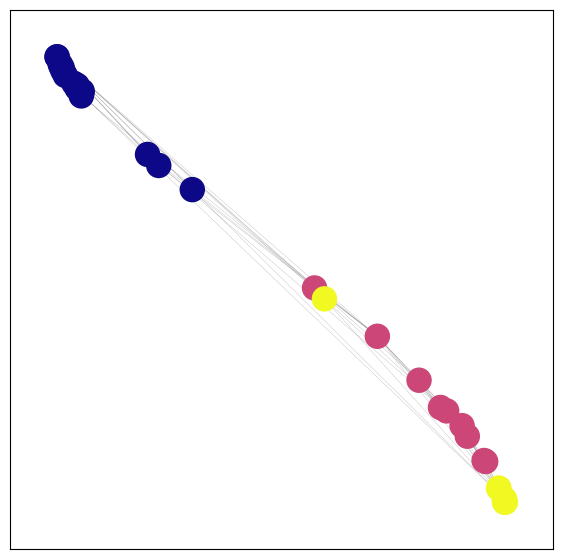

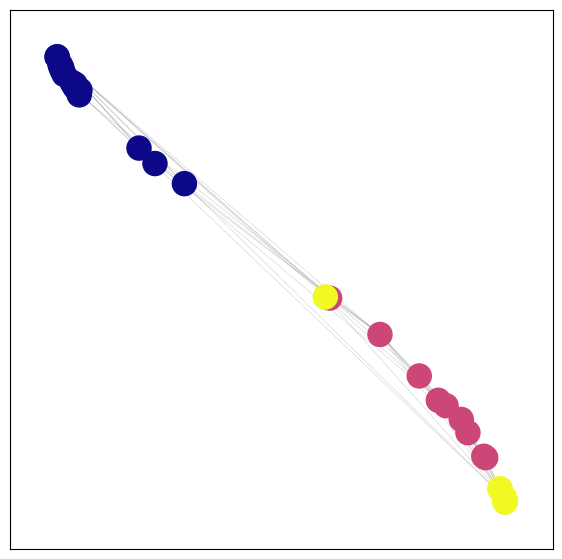

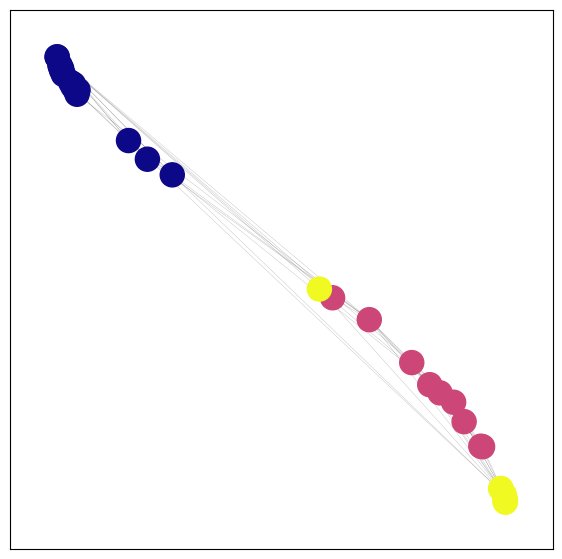

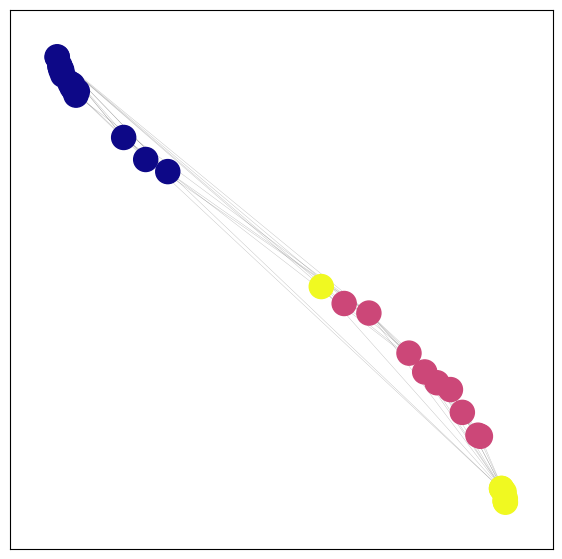

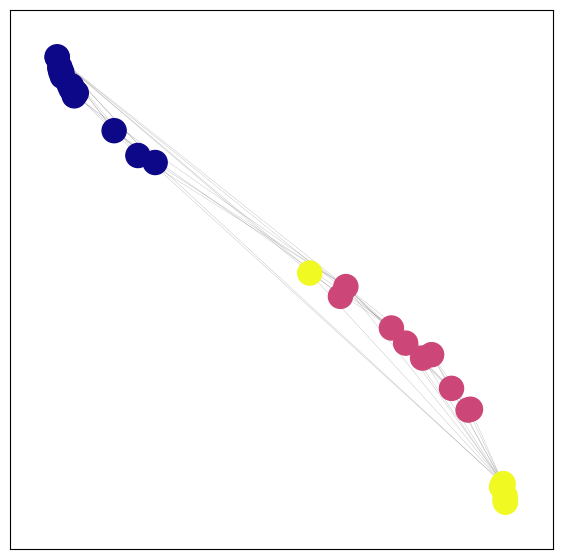

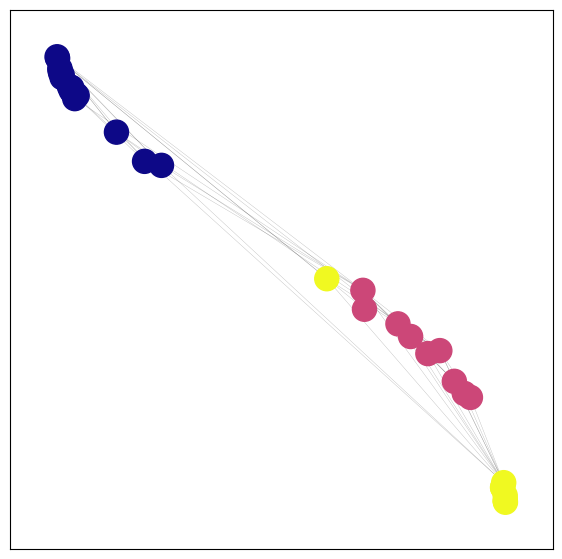

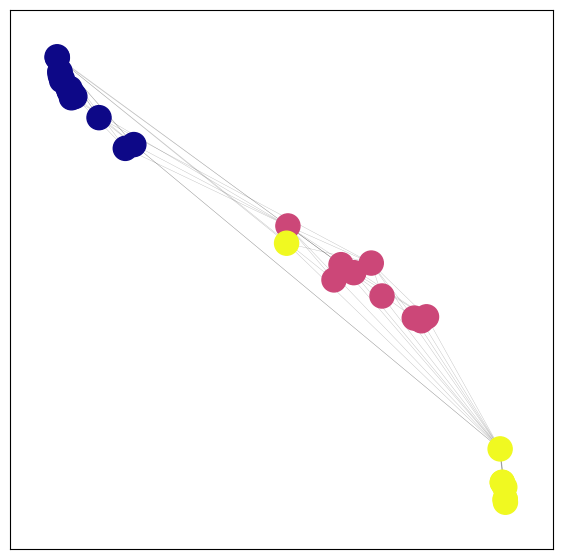

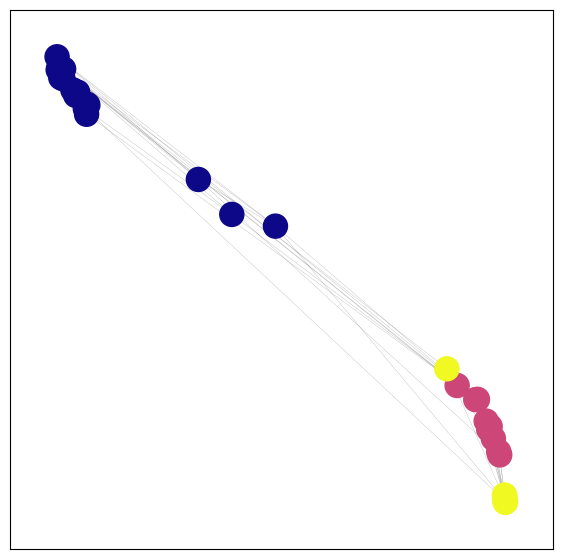

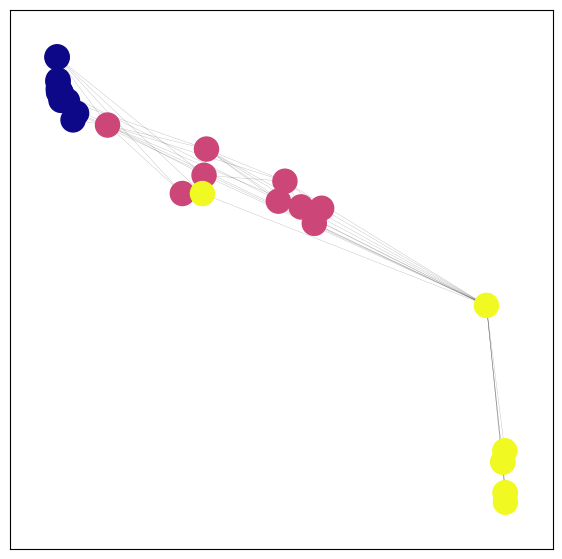

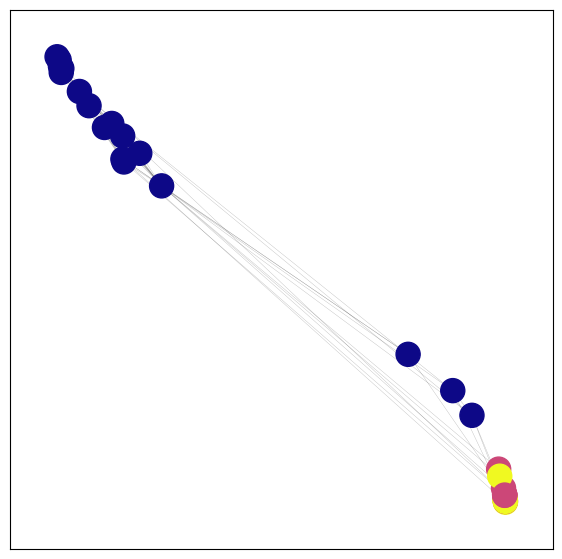

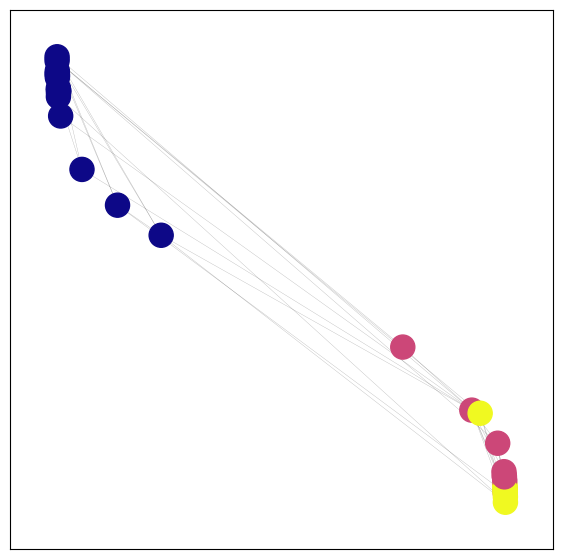

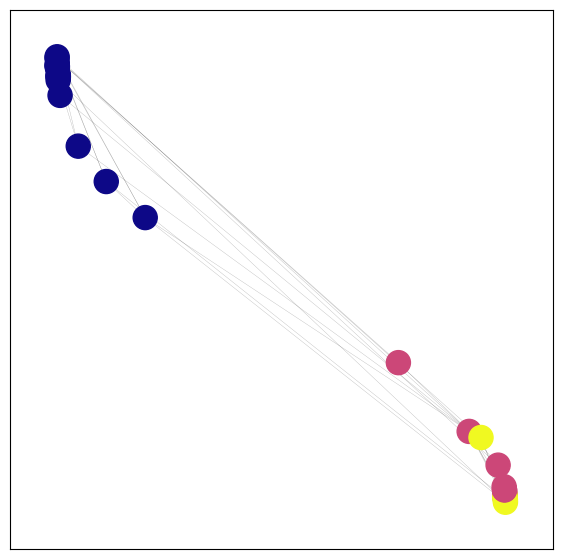

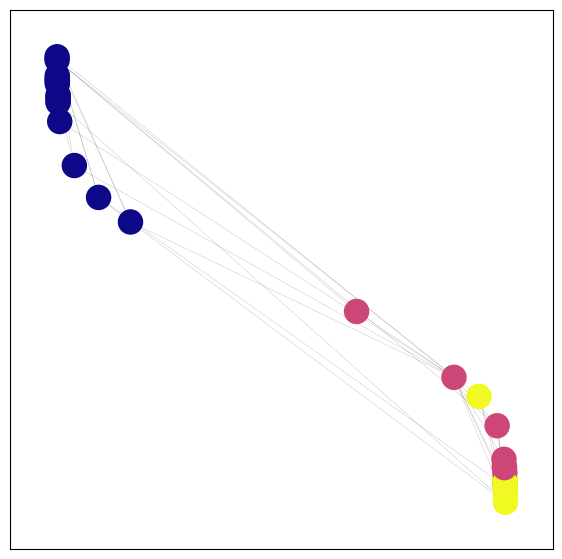

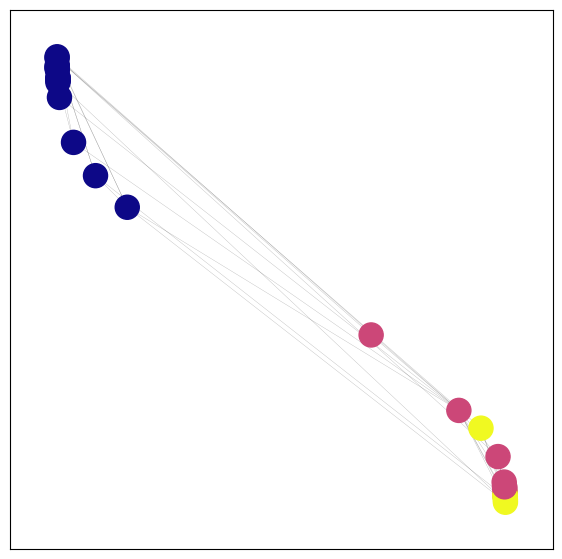

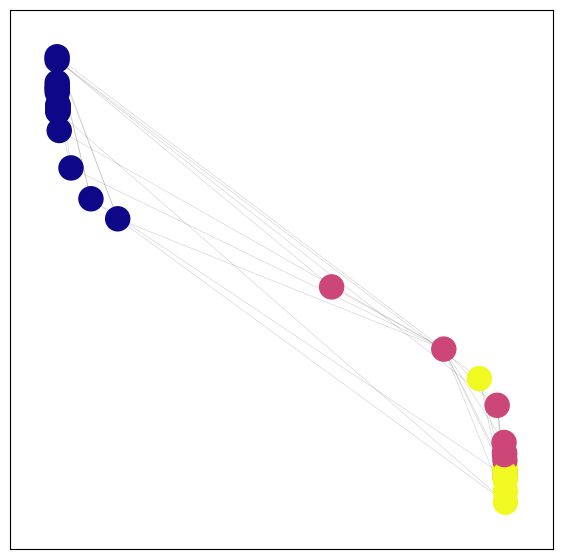

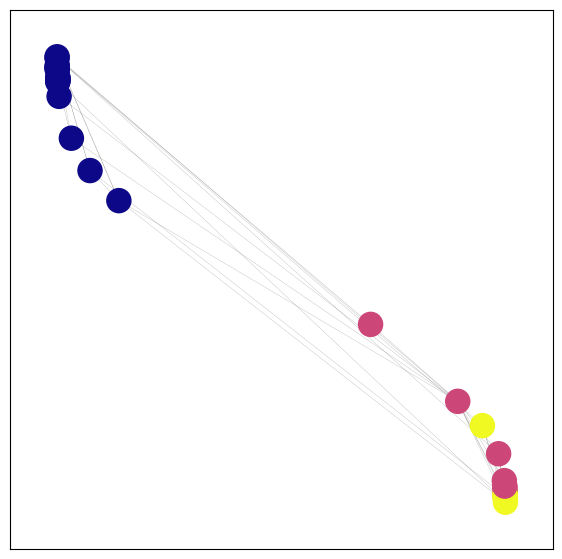

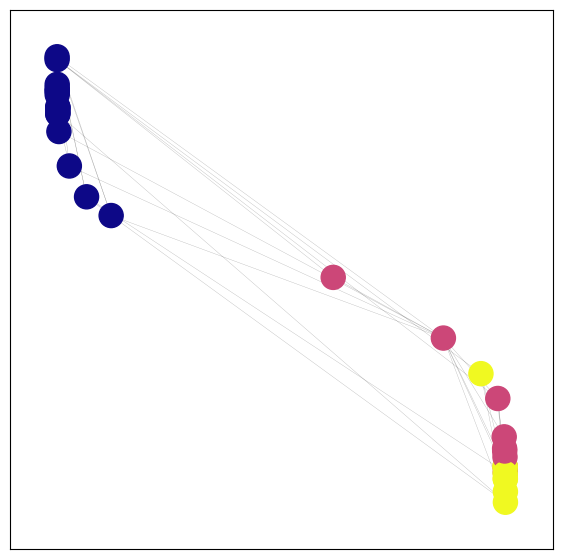

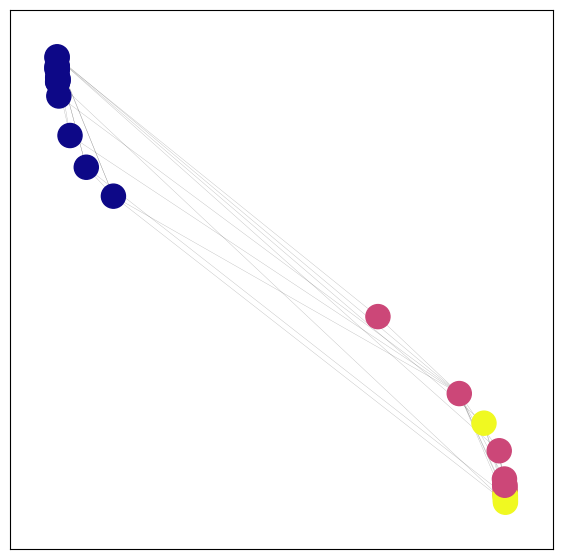

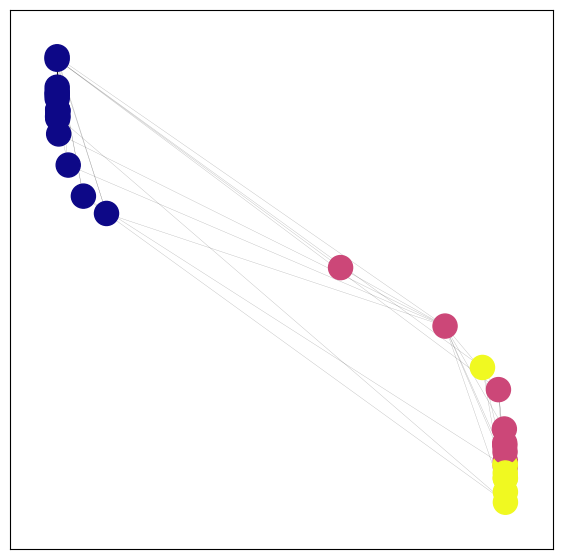

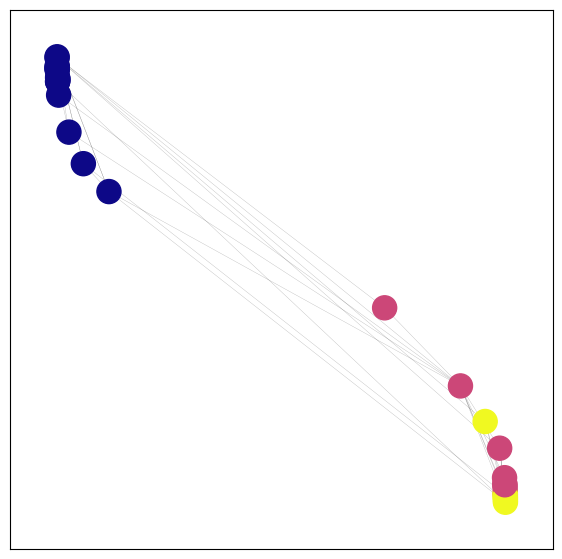

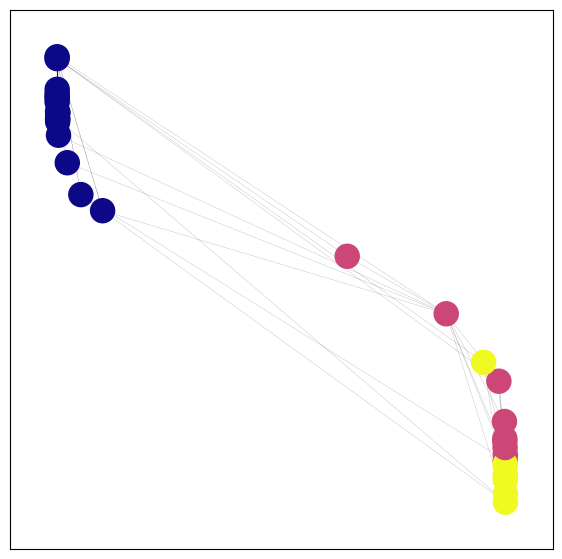

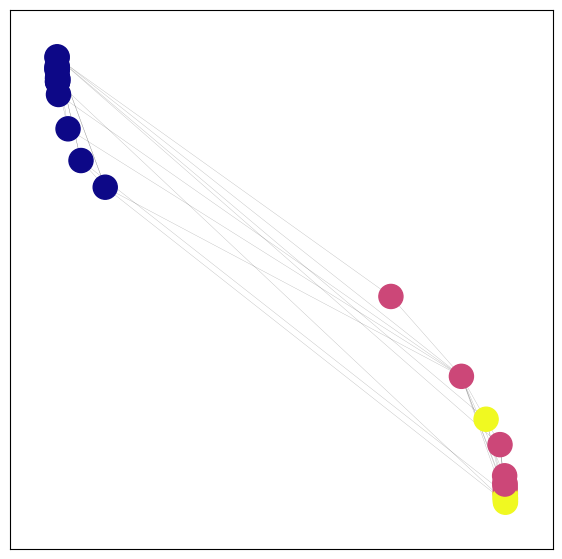

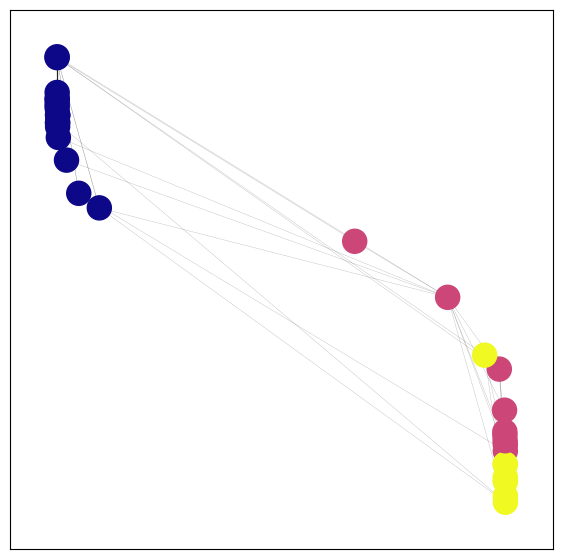

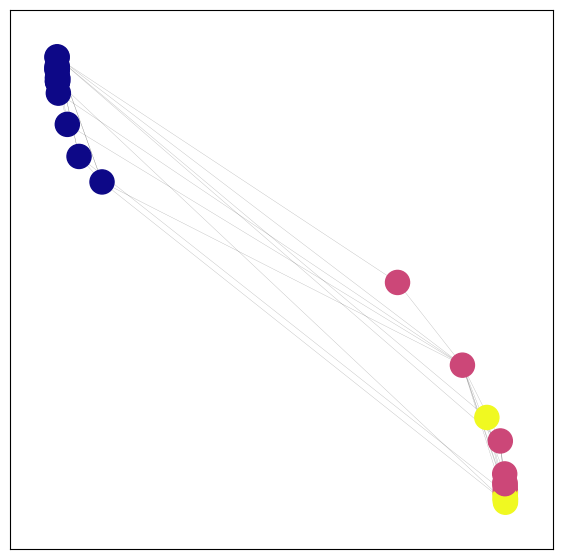

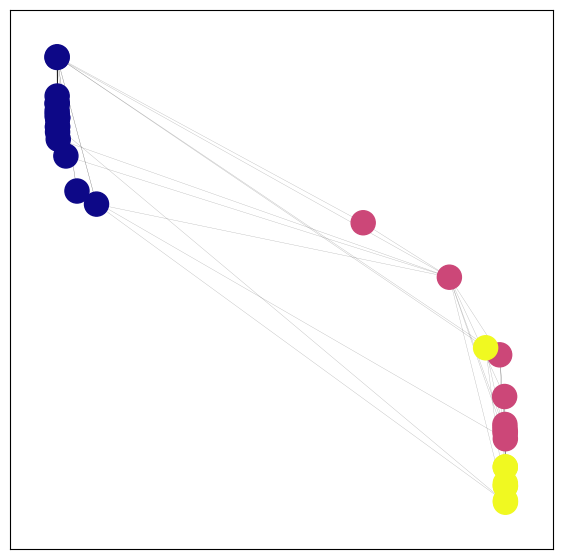

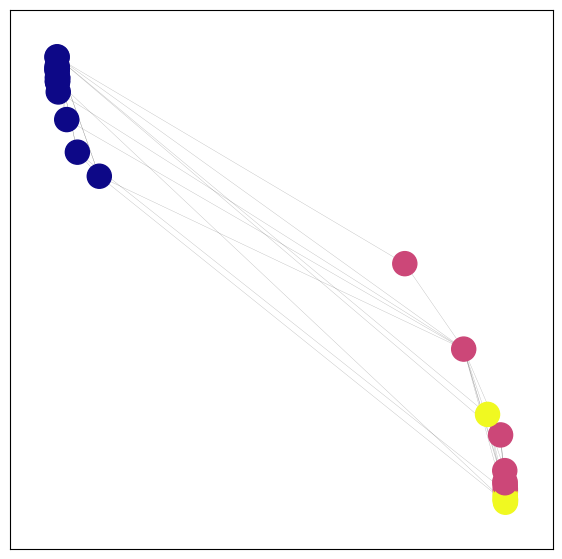

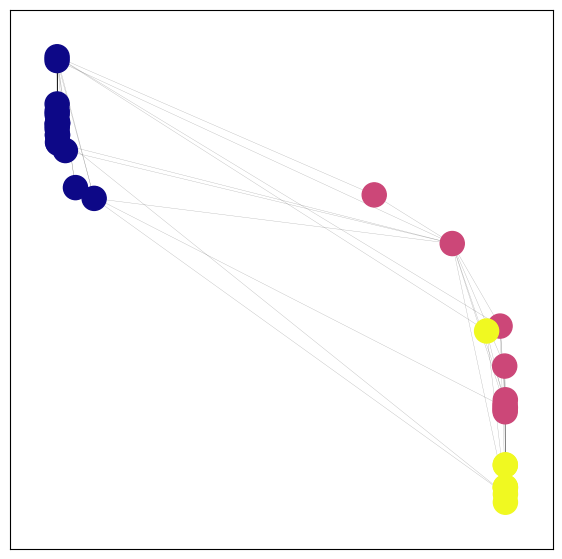

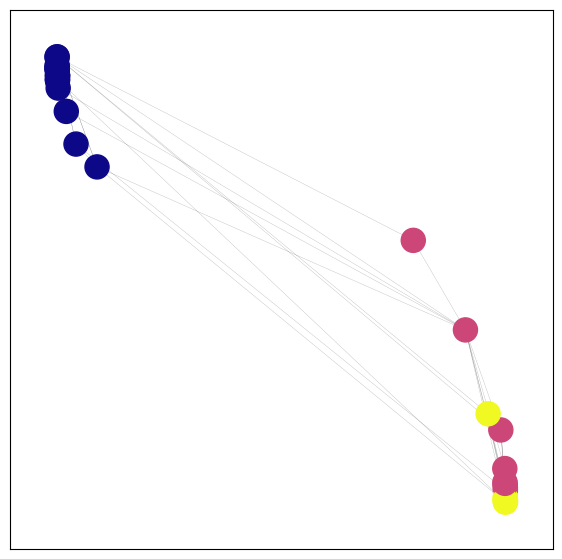

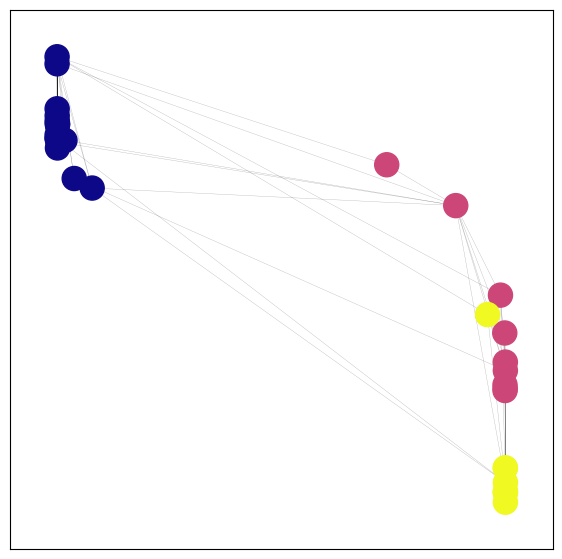

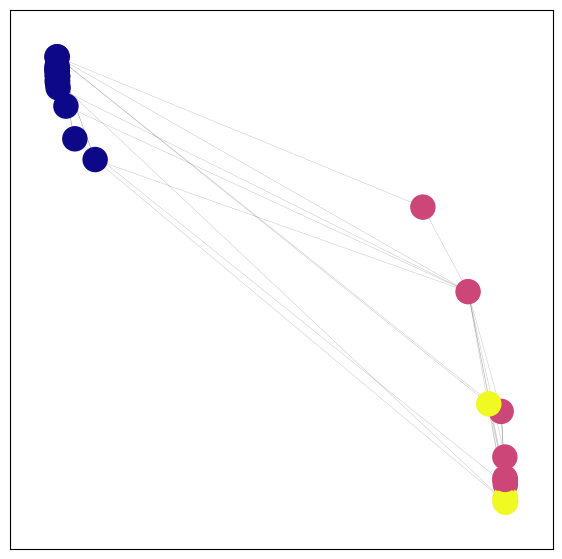

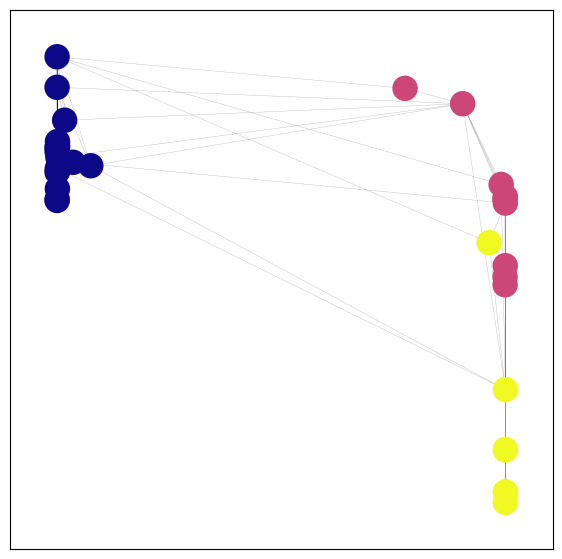

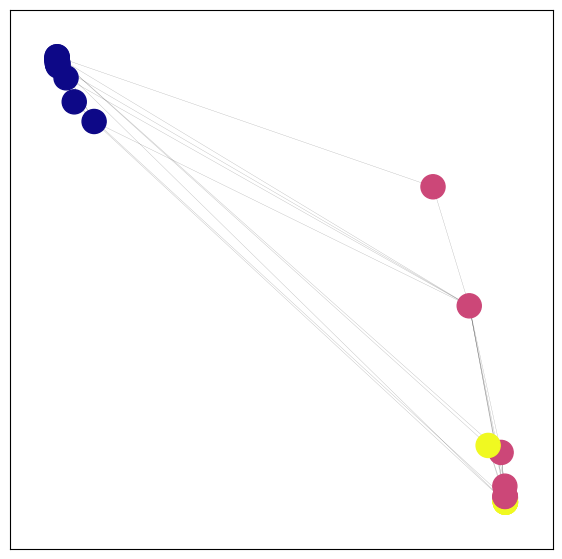

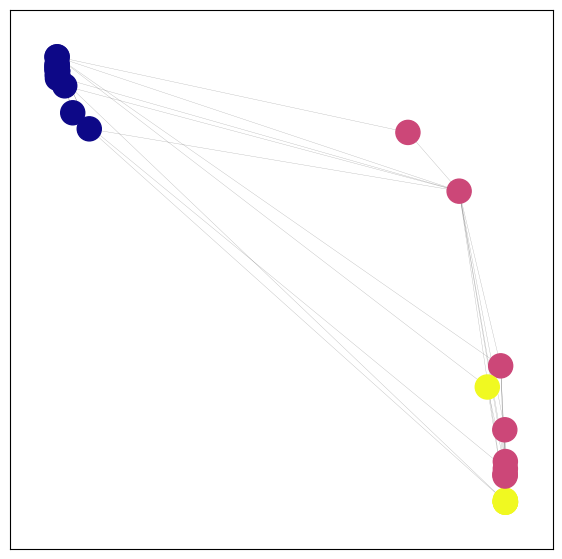

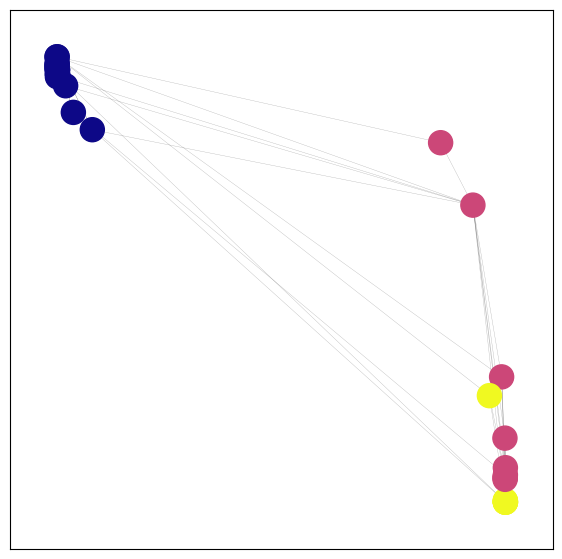

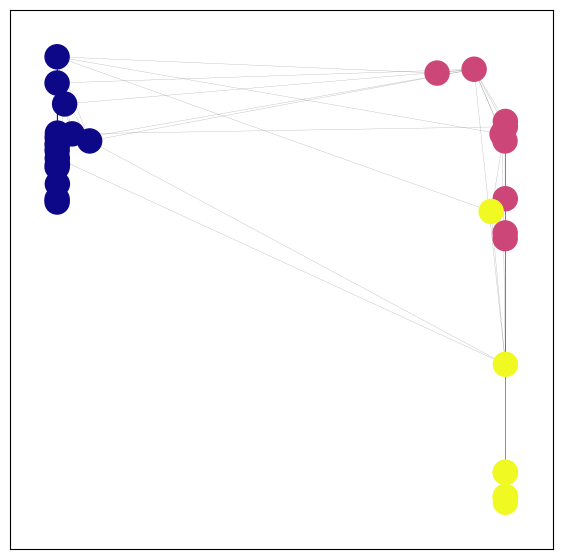

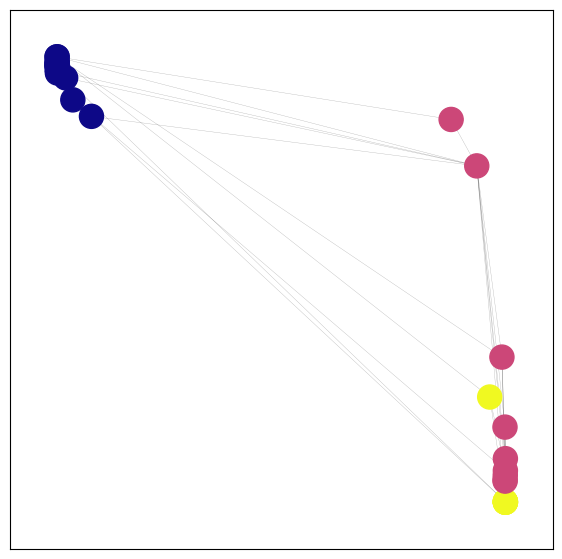

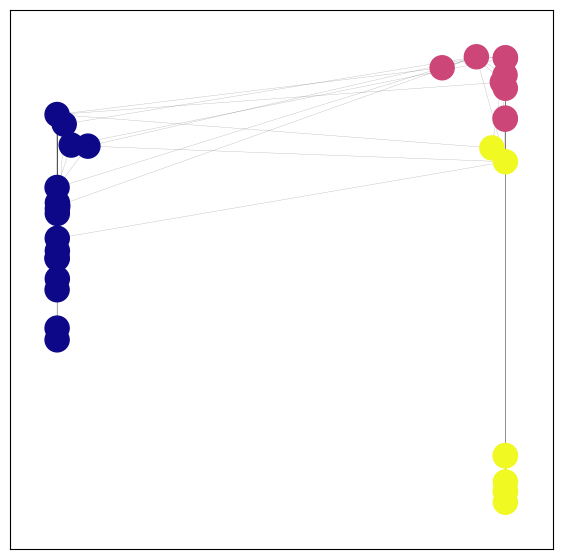

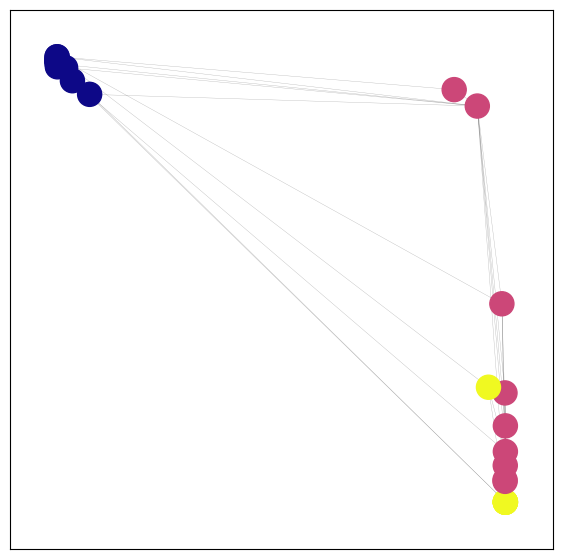

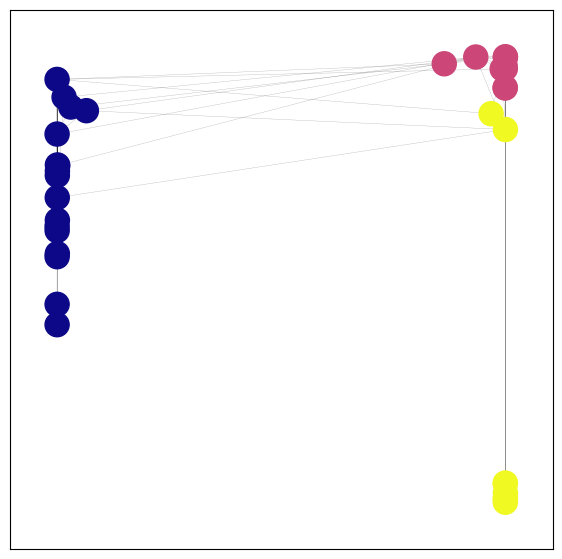

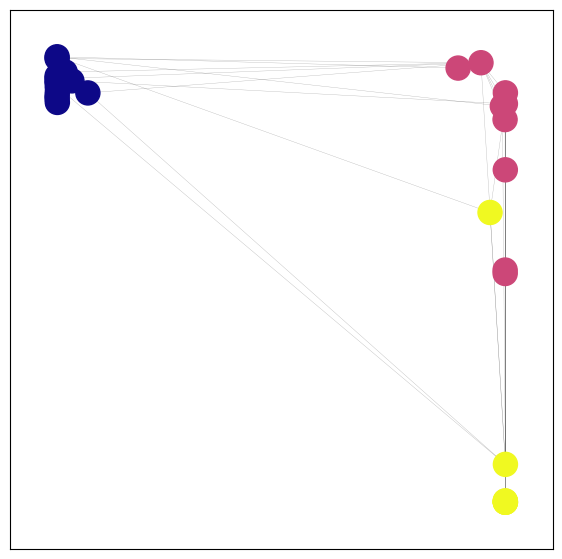

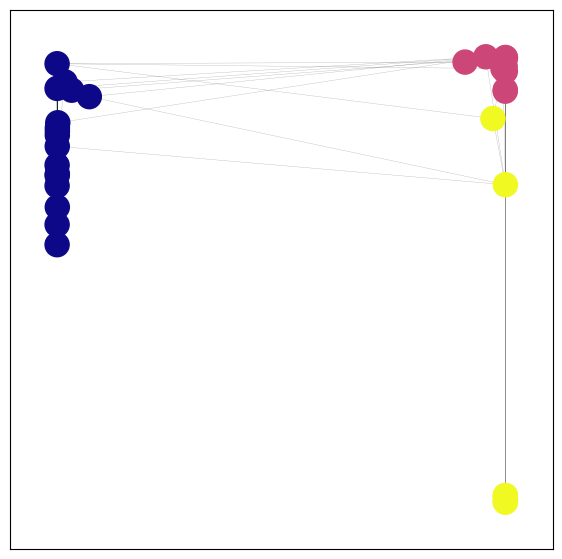

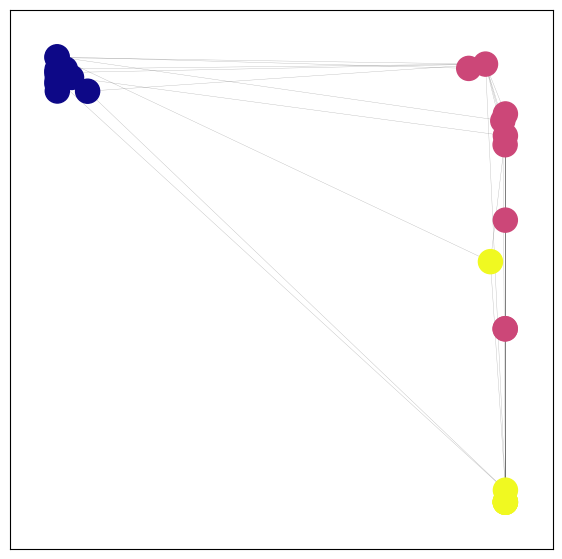

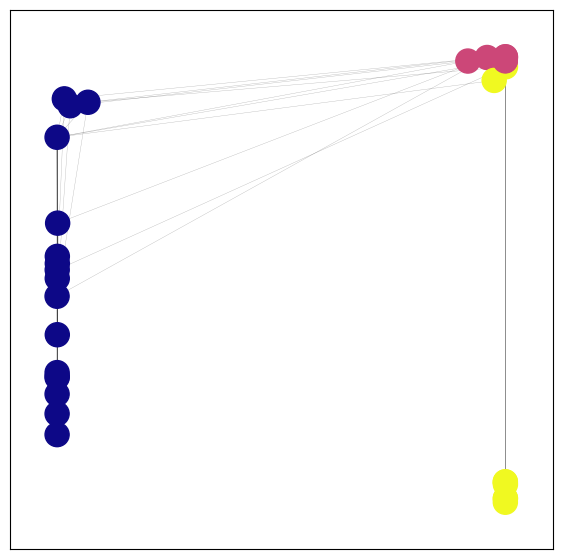

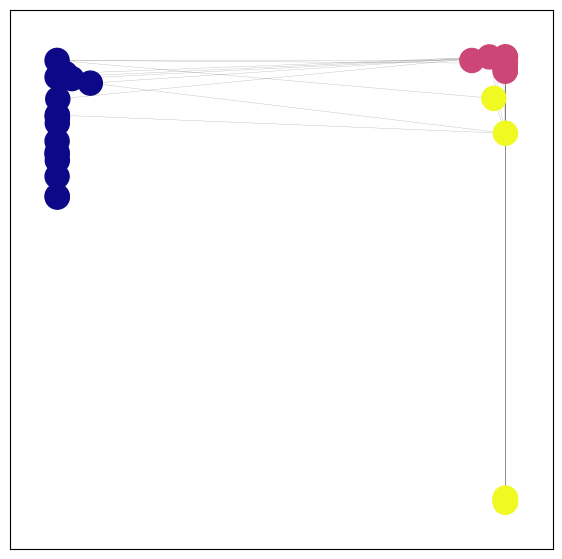

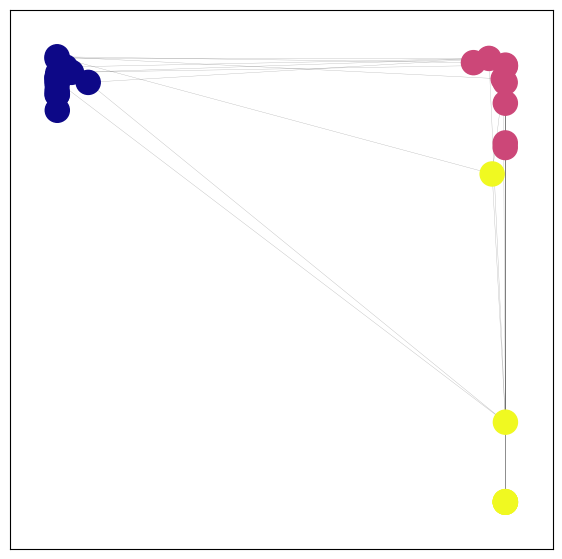

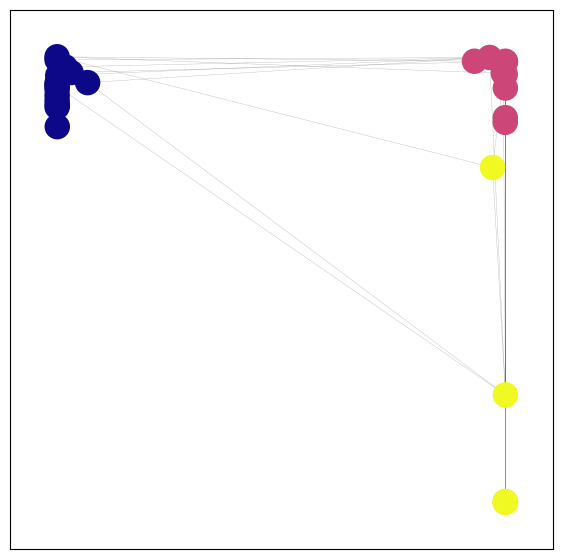

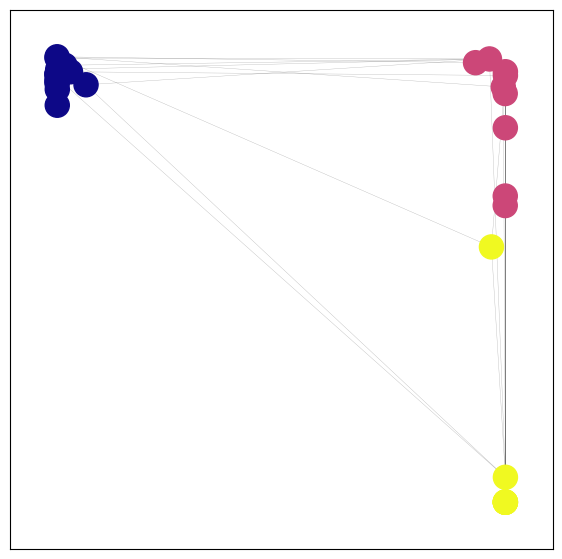

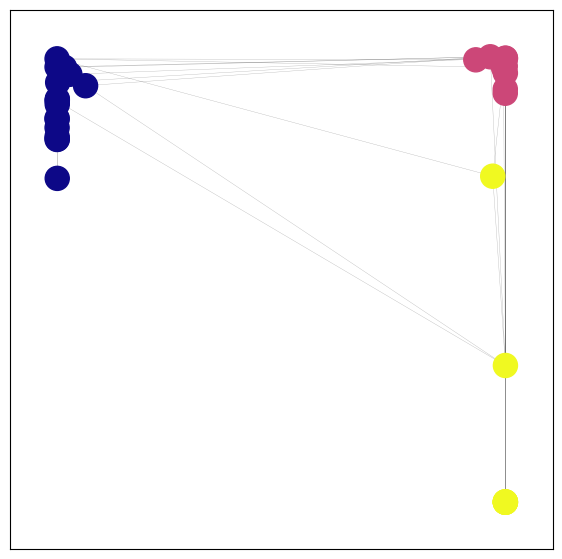

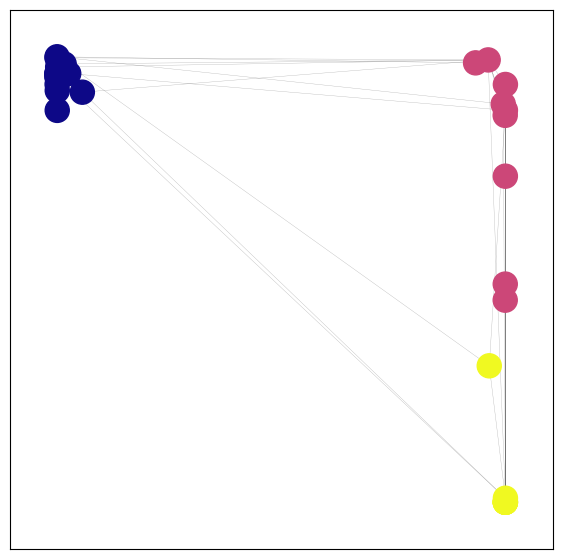

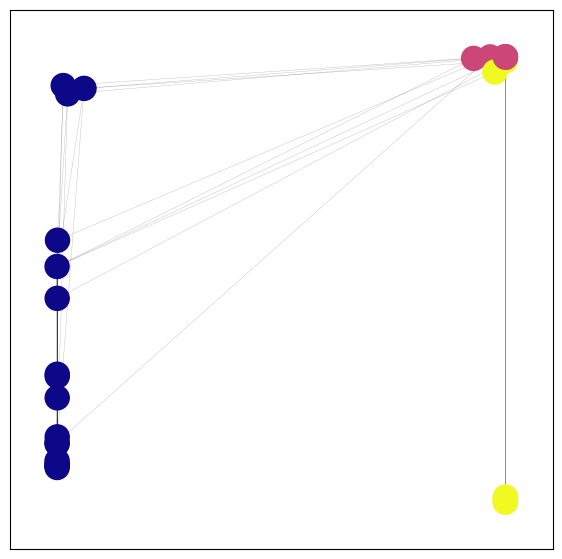

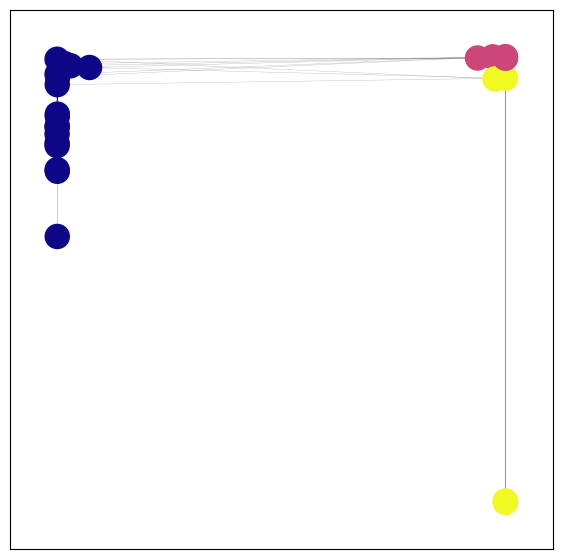

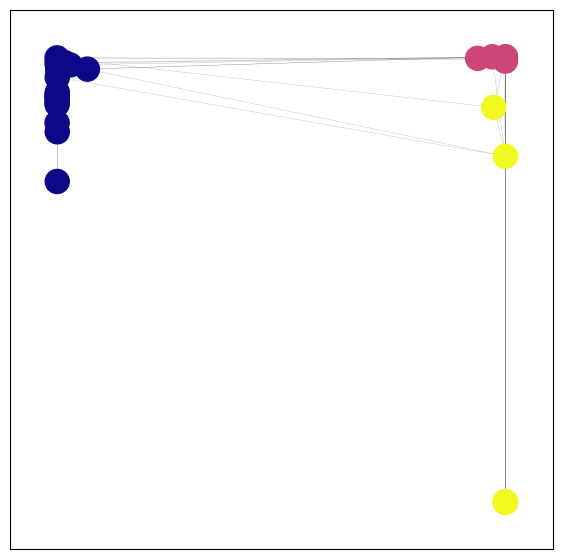

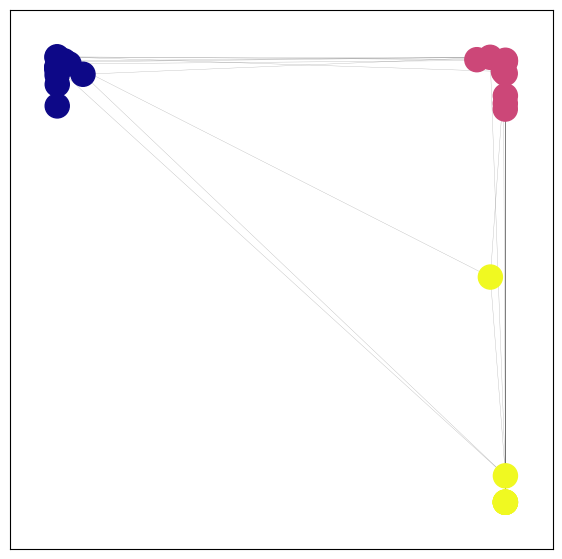

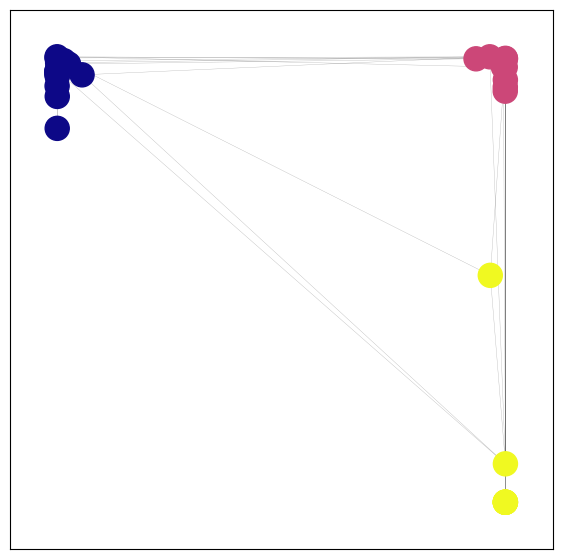

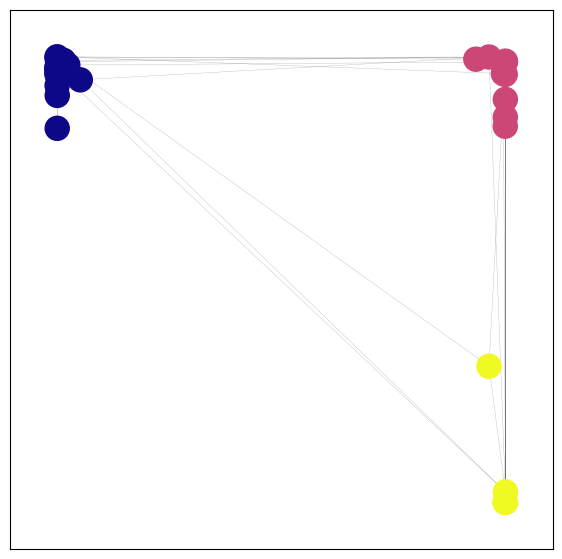

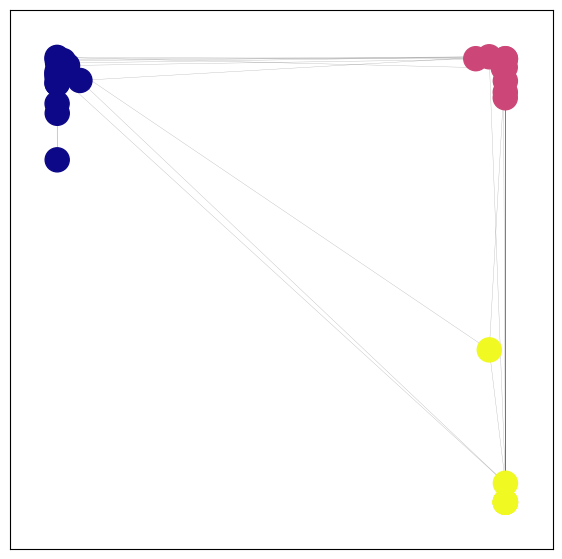

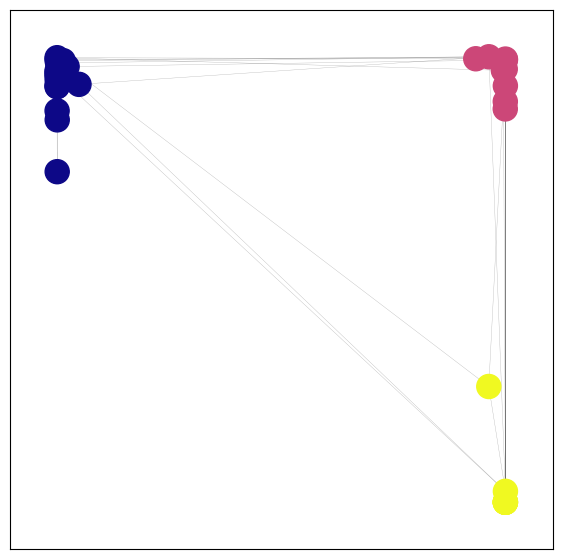

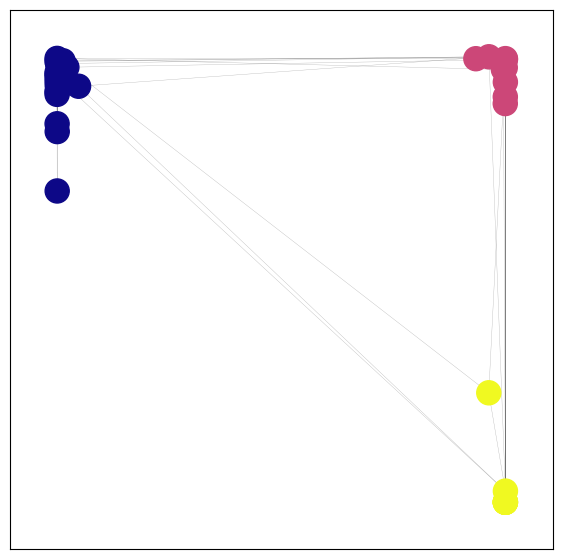

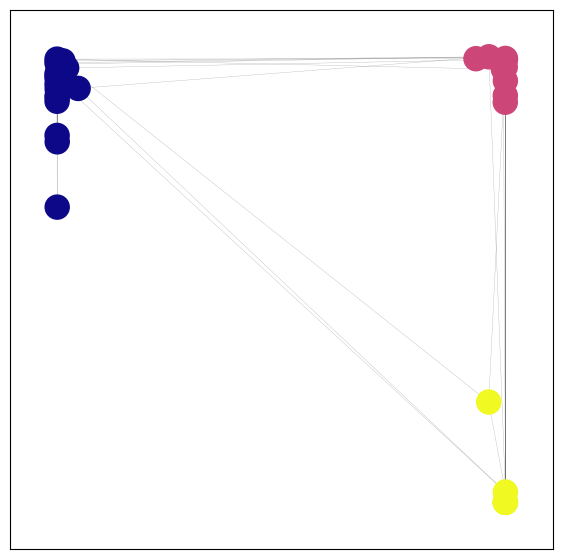

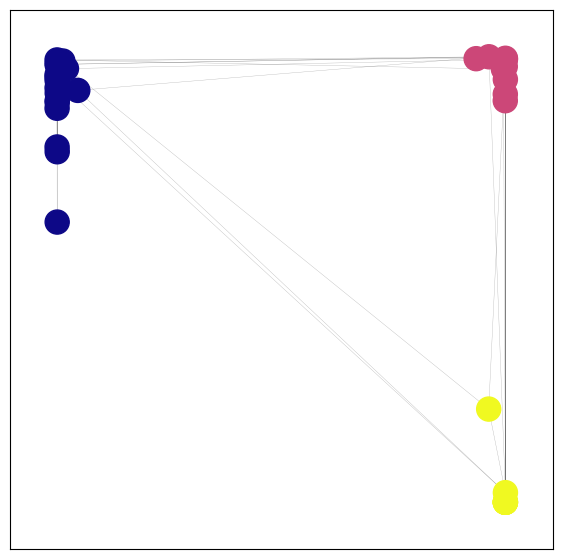

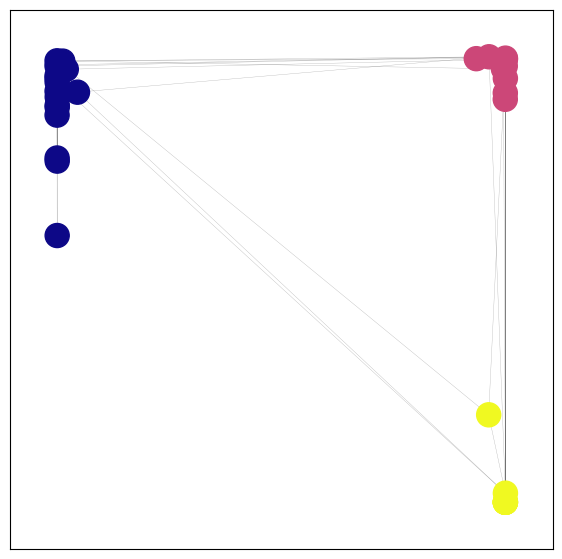

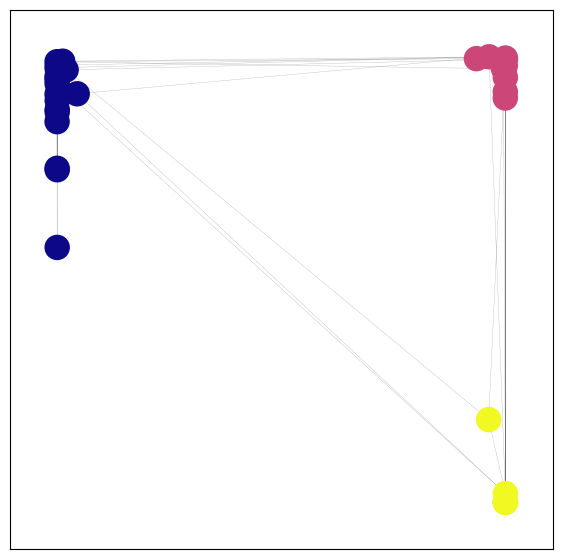

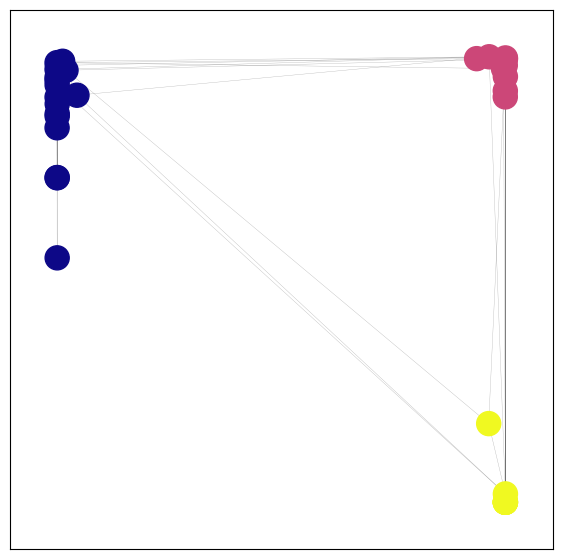

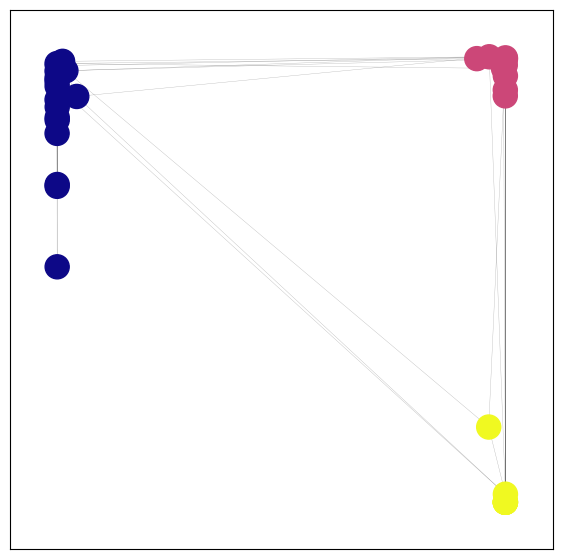

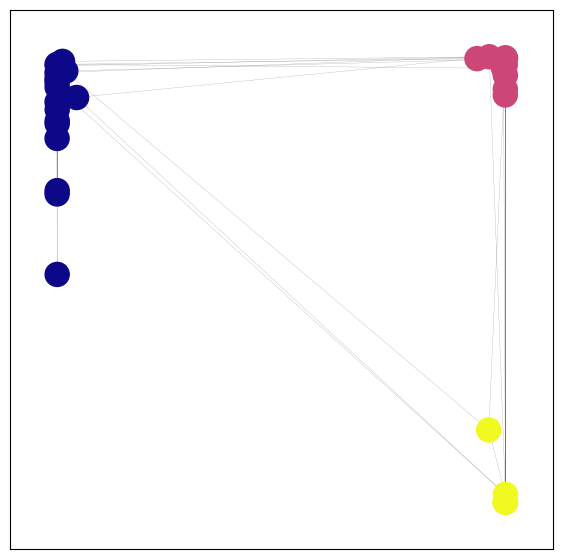

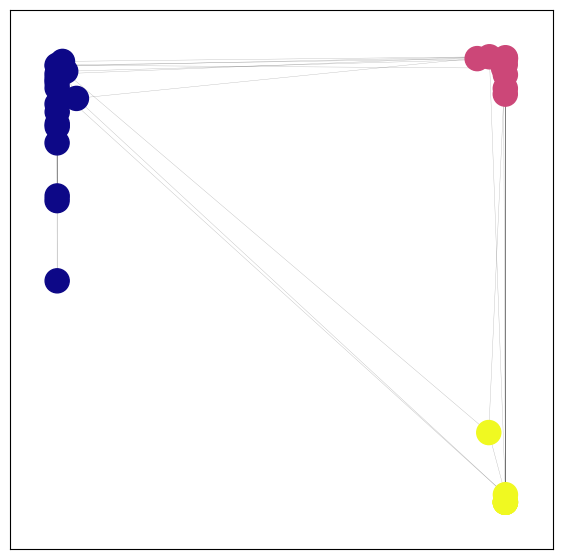

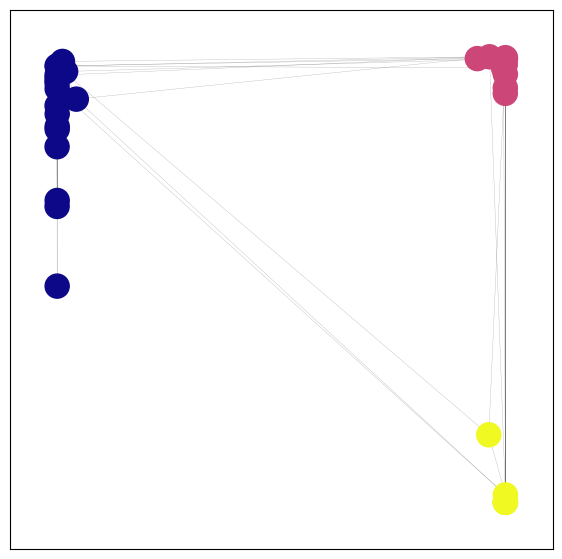

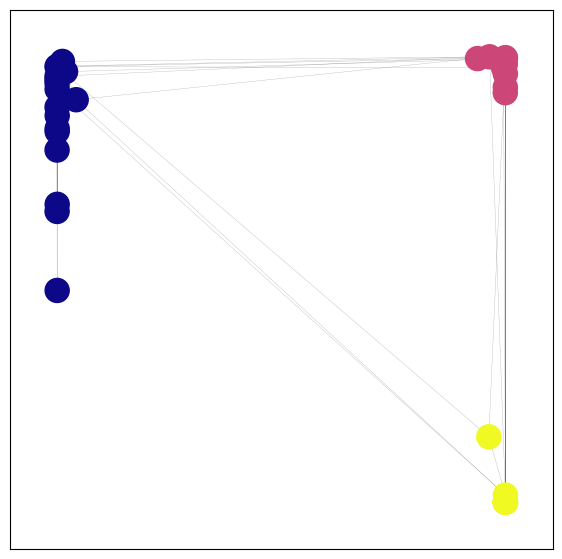

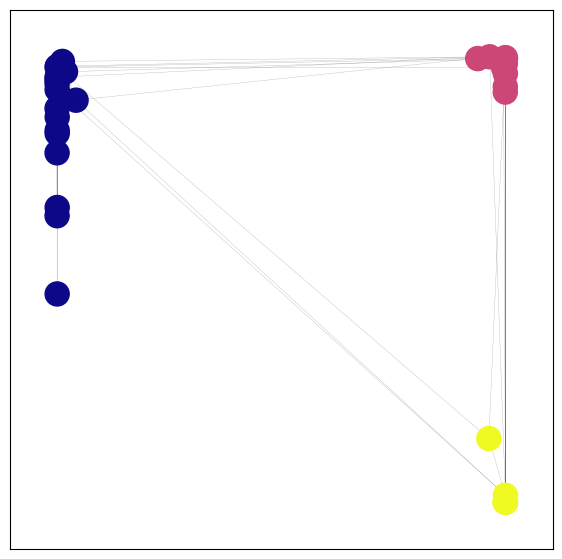

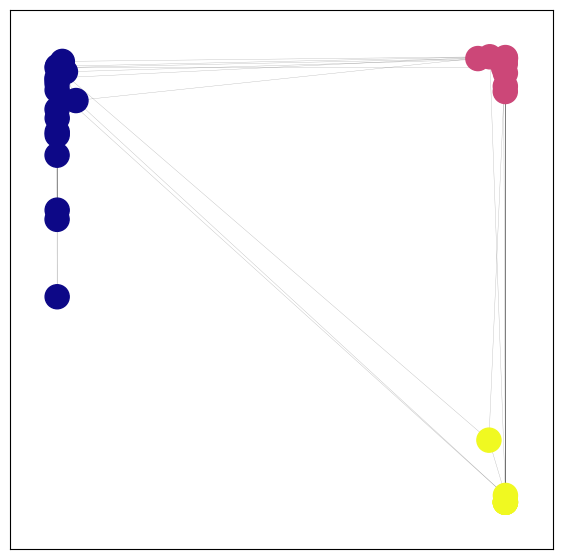

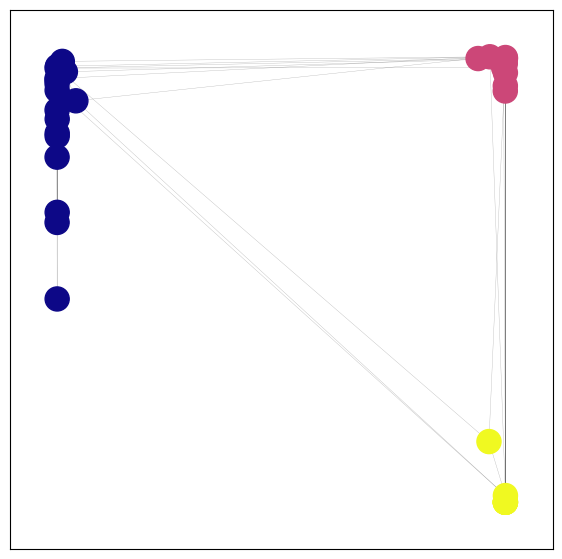

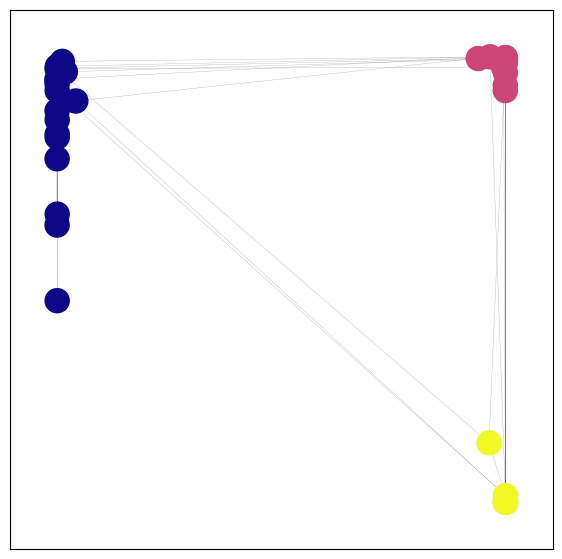

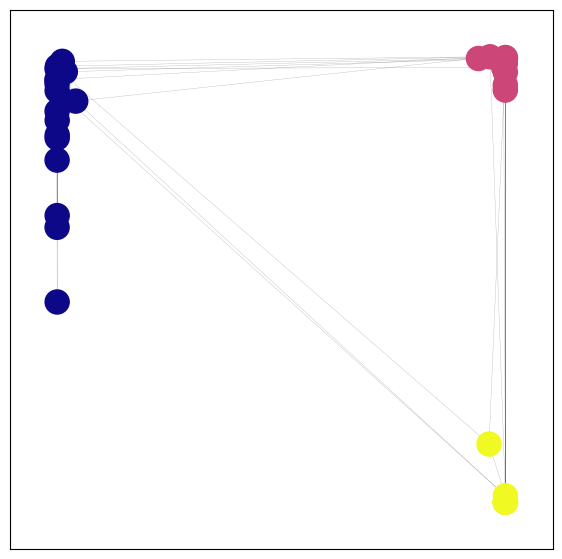

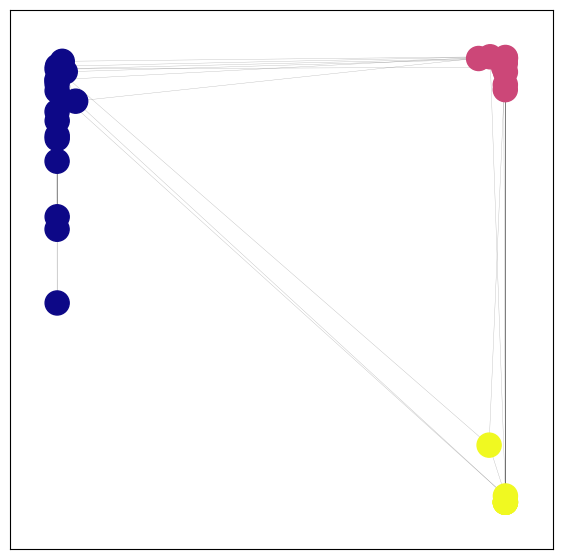

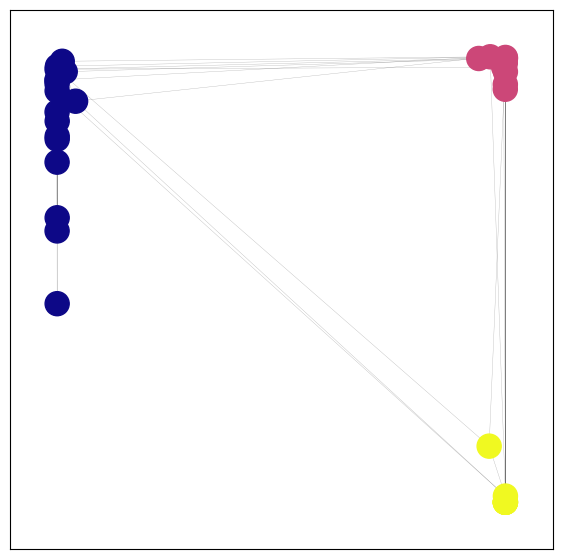

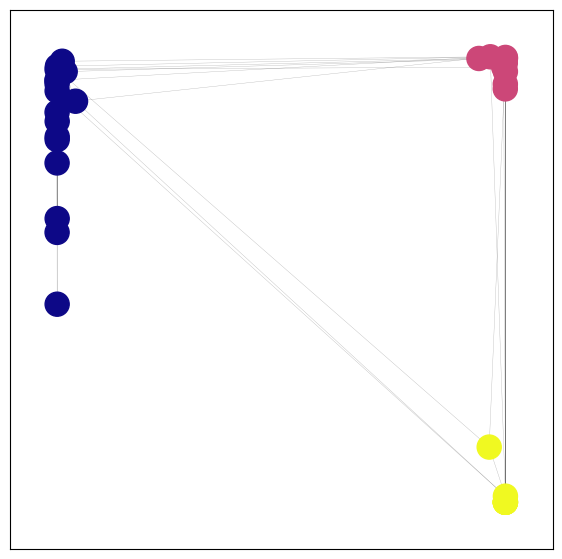

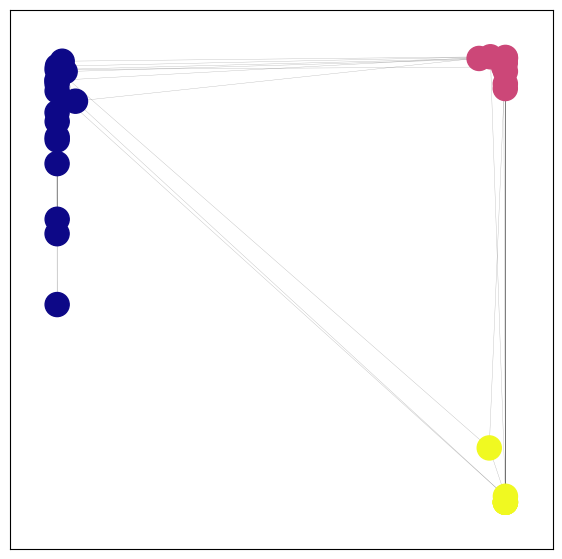

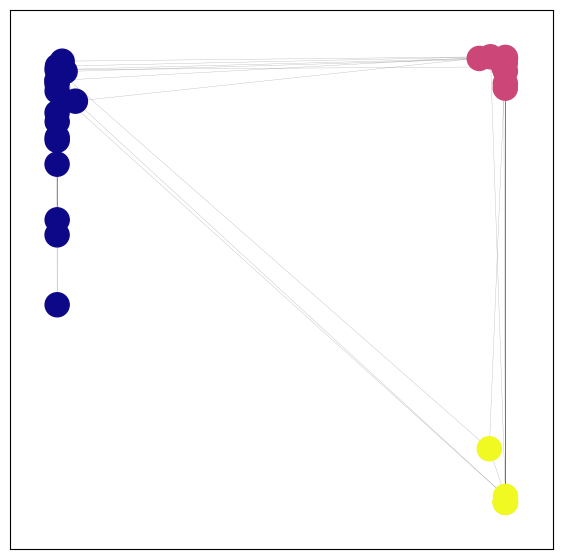

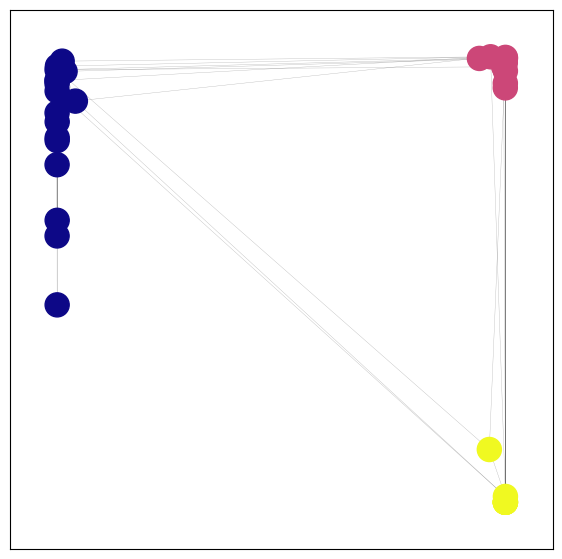

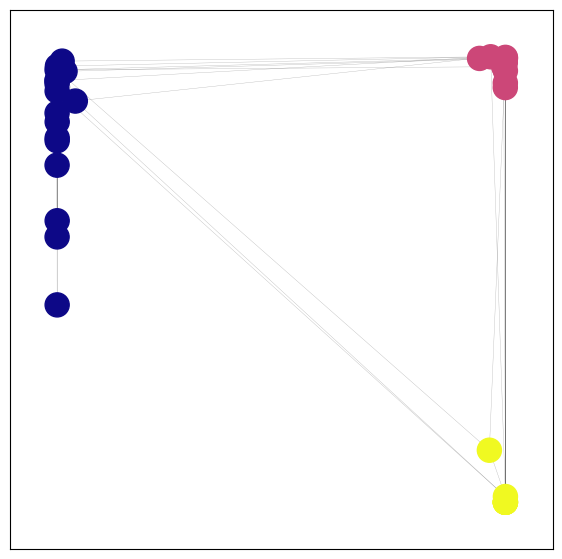

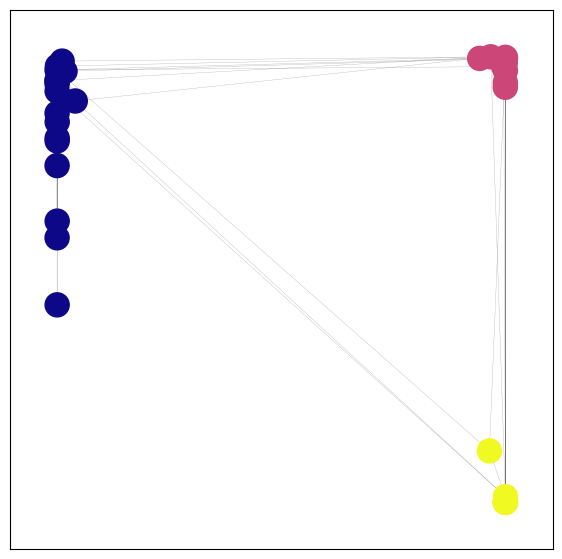

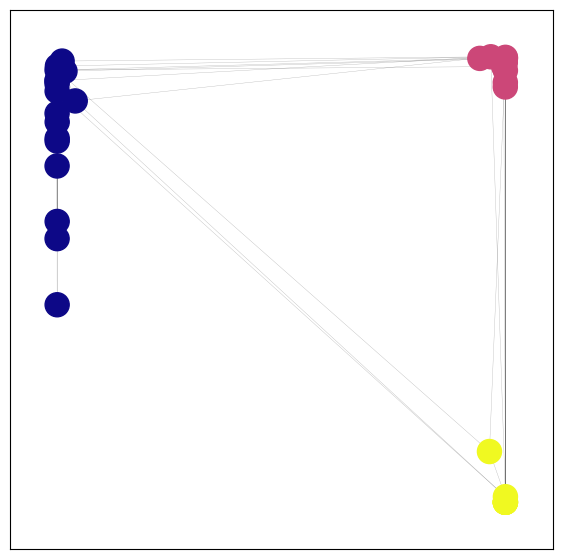

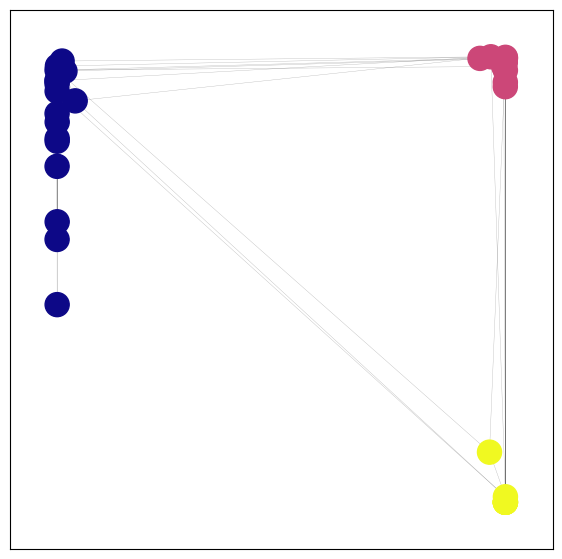

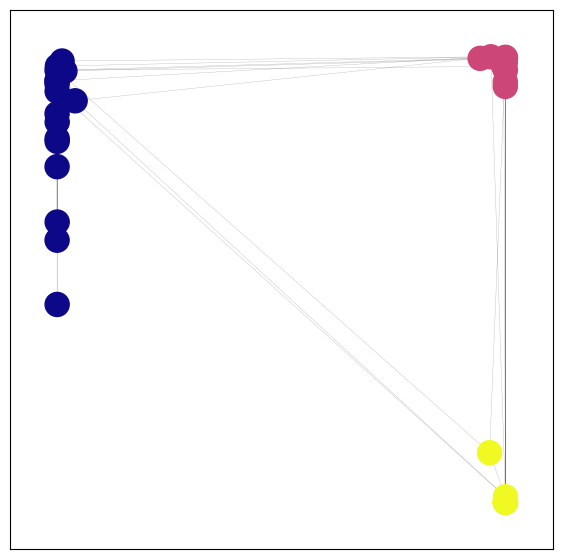

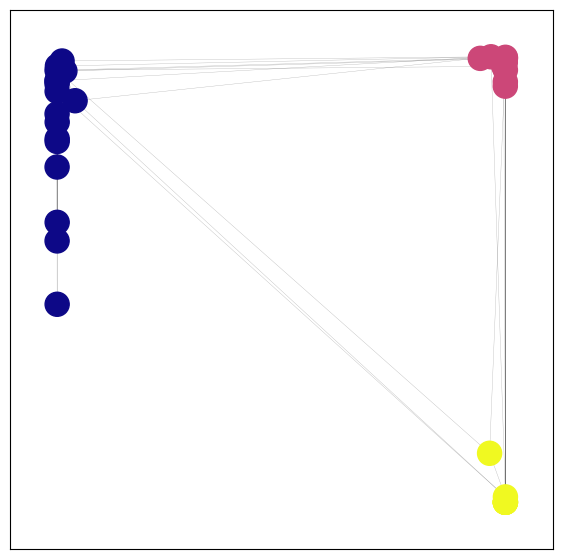

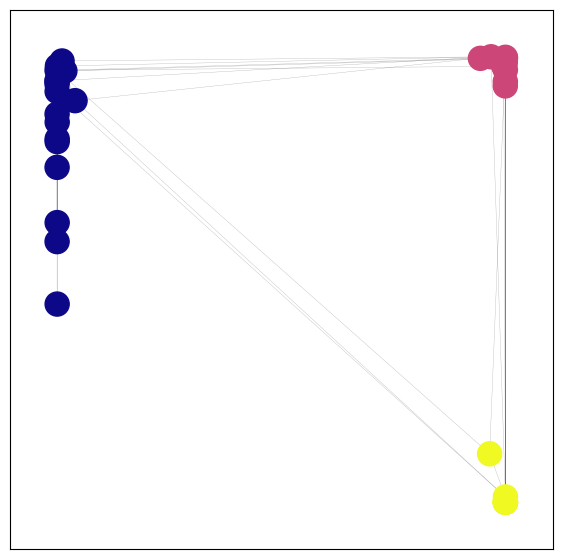

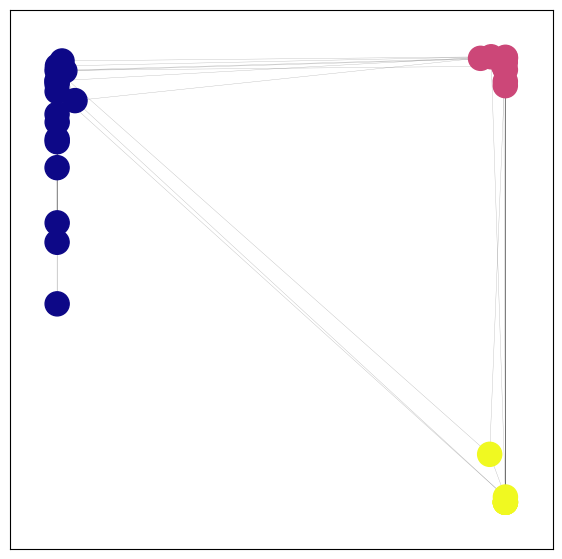

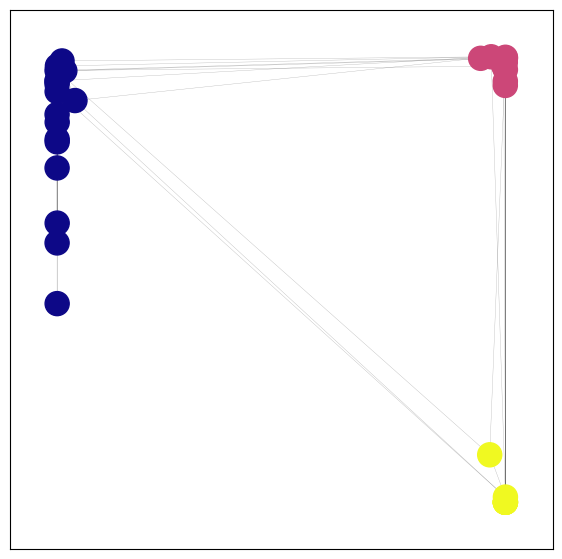

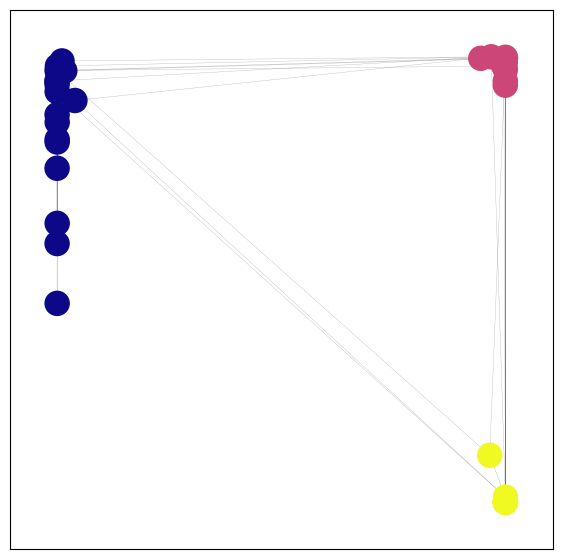

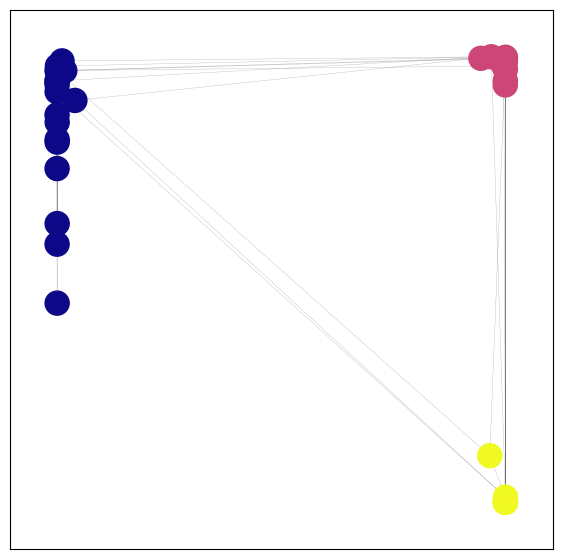

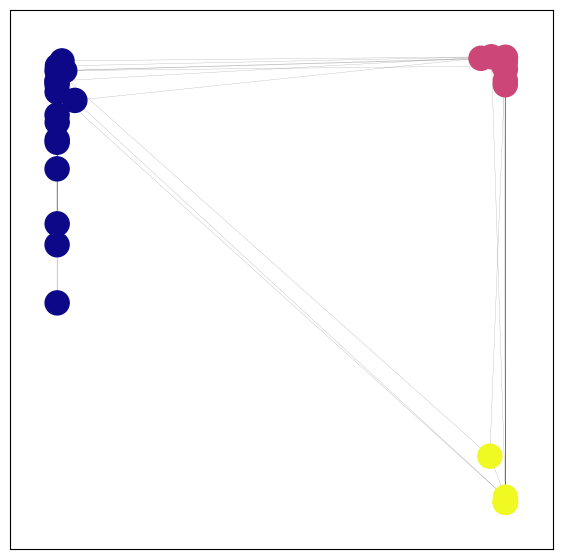

In [356]:
#save all images aross 100 epochs to a folder

images=[]
width = 200
center = width // 2
color_1 = (255,255,255)
results_dir =  #path name "C:\\Users\\nyadav\\Desktop...\\"

for ep in range(num_epochs):
    
    plt.figure(figsize=(7,7))
    embed_final = {i:np.asarray(embed[ep][i]).flatten() for i in range(embed[ep].shape[0])}
    nodes = nx.draw_networkx_nodes(g, embed_final,
                               cmap=plt.cm.plasma,
                               node_color=label_map)
    
    edges = nx.draw_networkx_edges(g, embed_final, width=0.25, alpha=0.3)
    if ep<10:
        sample_file_name = f"\\fig_Epoch 0{ep}.png"
    else:
        sample_file_name = f"\\fig_Epoch {ep}.png"

    plt.savefig(results_dir + sample_file_name)
               


In [363]:
#make a movie out of embedding changes

from PIL import Image

images =[] 
results_dir = #path name "C:\\Users\\nyadav\\Desktop...\\"

read_files = sorted(os.listdir(results_dir))

for filename in read_files: # loop through all png files in the folder
    im = Image.open(results_dir + filename) # open the image
    images.append(im) 



images[0].save('gif.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)


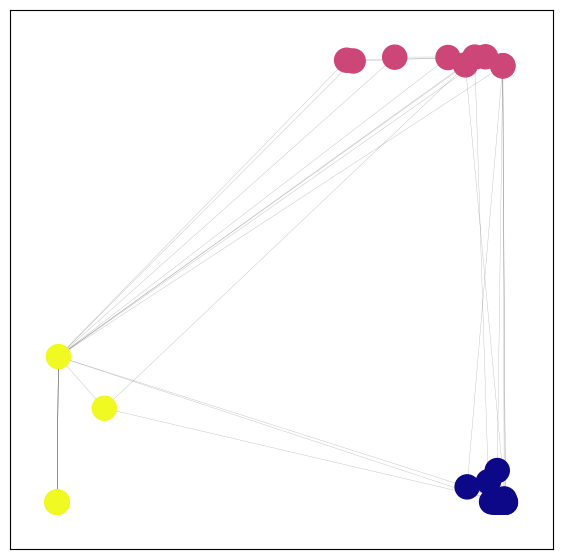

In [298]:
#plotting final embeddings


plt.figure(figsize=(7,7))
nodes = nx.draw_networkx_nodes(g, embed_final,
                               cmap=plt.cm.plasma,
                               node_color=label_map)
edges = nx.draw_networkx_edges(g, embed_final, width=0.25, alpha=0.3)



In [274]:
#GCN architecture
num_nodes = g.number_of_nodes()
num_classes = len(set(community))

g_nn = GCN_Network(3, [16,8,2], num_nodes, num_classes)
g_nn


GCNLayer Layer : Dimensions (34,16)
GCNLayer Layer : Dimensions (16,8)
GCNLayer Layer : Dimensions (8,2)
SoftMax Layer : Dimensions (2,3)

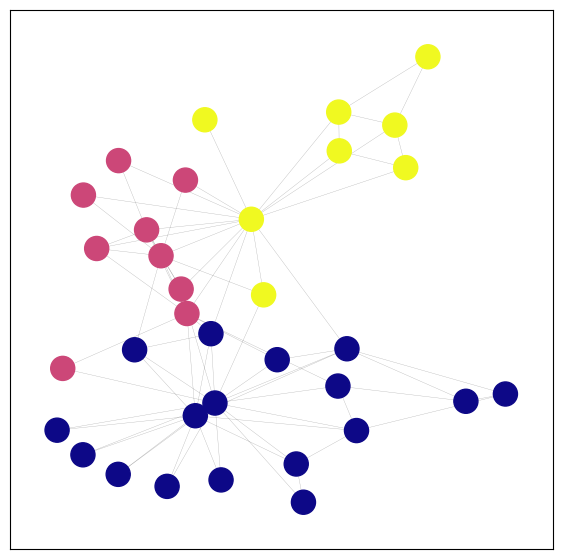

In [276]:
#plotting community embeddings we got earlier
plt.figure(figsize=(7,7))
nodes = nx.draw_networkx_nodes(g, pos,
                               cmap=plt.cm.plasma,
                               node_color=label_map)
edges = nx.draw_networkx_edges(g, pos, width=0.25, alpha=0.3)
plt.show()
